In [0]:
%pip install -i https://pypi.ap.burberry.com sd-data
%pip install holidays==0.24
%pip install prophet==1.1.2
%pip install lxml

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Looking in indexes: https://pypi.ap.burberry.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 44.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.9/499.9 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.27.1
    Not uninstalling holidays at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-4a86c868-a489-4452-a4df-8f1f554ea31e
    Can't uninstall 'holidays'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [0]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.4 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [0]:
import pandas as pd
import numpy as np
import os
#import networkx as nx
import seaborn as sns
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank, col
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from pyspark import SQLContext
import pyspark.sql
import pyspark.sql.functions as f
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as sts
import statistics as st
from numpy import mean, std, absolute
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils.validation import check_consistent_length, check_array
from sklearn.decomposition import PCA

# from tslearn.clustering import TimeSeriesKMeans, silhouette_score
# from tslearn.datasets import CachedDatasets
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from datetime import datetime, timedelta, date
from pyspark.sql.types import DateType
from pyspark.sql.window import Window
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import random
import logging
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import statsmodels.api as sm
from scipy.optimize import minimize

import sd_data
from sd_data import Transactions, Products, Footfall
from tabulate import tabulate

from sd_data.transformers.core import (
    pipeline,
    add_copy,
    add_coalesce,
    add_date,
    add_translation,
    add_cast,
    add_join,
    add_material,
    add_bool_from_match,
    add_fixed_column,
    apply_fillna,
    apply_filter,
    apply_sort,
    apply_select,
    apply_distinct,
    group_first,
    group_agg,
)

hyperparameter_tuning = False
random_treatment_test = False
prios_tuning = False
normal_run = True

logging.getLogger("py4j").setLevel(logging.ERROR)

spark.conf.set("spark.sql.execution.arrow.enabled", "false")
pd.set_option("display.float_format", lambda x: "%.1f" % x)

In [0]:
dbutils.widgets.removeAll()

In [0]:
traffic_params_dictionary = {
    "data_table": "user.ahutt.harrods_data_mainline",
    "date_column": "order_date",
    "date_format": "%Y-%m-%d",
    "control_column": "store_no",
    "treatment_values": "1316|1325|2578|1300|1335",
    "control_pool_column": "store_region",
    "control_pool_values": "EMEIA",
    "kpi_column": "gross_revenue",
    "impute_stores":"1210",
    "feature_selection": "6",
    "force_controls": "",
    "top_n_percent_largest_controls": "0.25",
    "train_start": "2021-04-01",
    "train_end": "2024-01-31",
    "test_start": "2024-02-01",
    "test_end": "2024-02-29",
    "treatment_start": "2024-02-01",
    "treatment_end": "2024-02-29",
    "train_start_rolling_window":"2021-04-01", # The start date of the dataset
    "train_end_rolling_window":"2023-07-31",
    "test_start_rolling_window": "2023-08-01",
    "test_end_rolling_window": "2024-01-31",
    "significance_value": "0.975",
    "change_points": "2023-08-01",
    "remove_controls_containing": "1010|1243|1000|1128|1291|1332|1289|1368|1009|1214|1020|1370", #1370 bad control
    "daily_weekly_aggregation": "daily",
    "length_of_training_output": "750",
    "clip_dates": "",
    "hyperparam_tune_bool":"True",
    "synthetic_control_df_path": "/Workspace/Users/yaxuan.shao@burberry.com/synthetic_control_data_Harrods.csv",
    "domain_df_path": "/Workspace/Users/yaxuan.shao@burberry.com/domain_df_Harrods.csv"
}
 
for key, value in traffic_params_dictionary.items():
    dbutils.widgets.text(key, value, key)

In [0]:
get_data_table = spark.table(dbutils.widgets.get("data_table"))
get_date_column = dbutils.widgets.get("date_column")
get_date_format = dbutils.widgets.get("date_format")
get_control_column = dbutils.widgets.get("control_column")
get_treatment_values = [str(store) for store in dbutils.widgets.get("treatment_values").split('|')]
get_control_pool_column = dbutils.widgets.get("control_pool_column")
get_control_pool_values = dbutils.widgets.get("control_pool_values").split('|')
get_kpi_column = dbutils.widgets.get("kpi_column")
get_impute_stores = dbutils.widgets.get("impute_stores").split('|')
get_feature_selection = int(dbutils.widgets.get("feature_selection"))
get_force_controls = dbutils.widgets.get("force_controls").split('|')
get_top_n_percent_largest_controls = float(dbutils.widgets.get("top_n_percent_largest_controls"))
get_hyperparam_tune_bool = dbutils.widgets.get("hyperparam_tune_bool")

get_train_start = datetime.strptime(dbutils.widgets.get("train_start"), get_date_format)
get_train_end = datetime.strptime(dbutils.widgets.get("train_end"), get_date_format)
get_test_start = datetime.strptime(dbutils.widgets.get("test_start"), get_date_format)
get_test_end = datetime.strptime(dbutils.widgets.get("test_end"), get_date_format)
get_treatment_start = datetime.strptime(dbutils.widgets.get("treatment_start"), get_date_format)
get_treatment_end = datetime.strptime(dbutils.widgets.get("treatment_end"), get_date_format)

get_train_start_rolling_window = datetime.strptime(dbutils.widgets.get("train_start_rolling_window"), get_date_format)
get_train_end_rolling_window = datetime.strptime(dbutils.widgets.get("train_end_rolling_window"), get_date_format)
get_test_start_rolling_window = datetime.strptime(dbutils.widgets.get("test_start_rolling_window"), get_date_format)
get_test_end_rolling_window = datetime.strptime(dbutils.widgets.get("test_end_rolling_window"), get_date_format)

get_significance_value = float(dbutils.widgets.get("significance_value"))
get_change_points = [datetime.strptime(changepoint, get_date_format) for changepoint in  dbutils.widgets.get("change_points").split('|')]
get_remove_controls_containing = dbutils.widgets.get("remove_controls_containing").split('|')
get_daily_weekly_aggregation = dbutils.widgets.get("daily_weekly_aggregation")
get_length_of_training_output = int(dbutils.widgets.get("length_of_training_output"))
get_synthetic_control_df_path  = dbutils.widgets.get("synthetic_control_df_path")
get_domain_df_path  = dbutils.widgets.get("domain_df_path")
#get_clip_dates = [datetime.strptime(changepoint, get_date_format) for changepoint in  dbutils.widgets.get("clip_dates").split('|')]

In [0]:
def remove_stores_containing_phrases(df_stores, remove_stores_containing, variable):
    if variable in df_stores.columns:
        if type(remove_stores_containing) == list:
            # remove stores with name containing any of these strings i.e. " MW" or " CW" Menswear Childrenswear
            init_stores = df_stores.select(variable).distinct().count()
            for cutword in remove_stores_containing:
                print(f"trying to remove {cutword}")
                df_stores = df_stores.withColumn(
                    "contains_phrase",
                    f.when(f.col(variable).contains(cutword), True).otherwise(False),
                ).filter(f.col("contains_phrase") == False)
            stores_dropped = init_stores - df_stores.select(variable).distinct().count()
            print(f"Stores Cut by {variable}: {stores_dropped}/{init_stores}")
    else:
        pass
    return df_stores
  
def convert_dates_to_datetime(sdf, date_col, date_format):
    return sdf.withColumn(date_col, f.to_date(date_col, format=date_format))
  
def filter_top_n_largest_control_candidates(sdf, control_col, kpi_col, treatment_values, n_percent):
    window = Window.orderBy(f.col(f"{kpi_col}_size").desc())

    mean_stores = (
        sdf.filter(f.col(kpi_col).isNotNull()).filter(f.col(kpi_col) > 0).groupBy(control_col)
        .agg(f.mean(kpi_col).alias(f"{kpi_col}_size"))
        .orderBy(f.col(f"{kpi_col}_size").desc())
    ).withColumn("row_number", f.row_number().over(window))

    # Filter the DataFrame to keep the top half and rows with store_no in treatment_values
    mean_stores_filtered = mean_stores.filter(
        (f.col("row_number") <= mean_stores.count() * n_percent) |
        (f.col(control_col).isin(treatment_values))
    ).drop("row_number")

    total_controls, filtered_controls = mean_stores.select(control_col).distinct().count(), mean_stores_filtered.select(control_col).distinct().count()

    print(f"Filter Largest Controls: {total_controls} --> {filtered_controls}")

    return sdf.join(mean_stores_filtered, control_col, "inner")

def keep_top_n_percent_of_controls(sdf, relative_size_col, n_percent):
  return sdf.filter(f.col(relative_size_col)>f.col(relative_size_col))

def aggregate_pilot_stores(sdf, treated_values, control_col, date_col, kpi_col):
    # use all days of that week from all years to determine a median benchmark to compare footfall against

    print(treated_values)
    
    sdf = sdf.withColumn(
        "treated_values_and_controls",
        f.when(f.col(control_col).isin(treated_values), "Agg_Pilot_Stores").otherwise(
            f.col(control_col)
        ),
    )

    if "store_name" in sdf.columns:
        treatment_stores_included = [i[0] for i in sdf.filter(f.col("treated_values_and_controls")=='Agg_Pilot_Stores').select("store_name").distinct().collect()]

        print(f"Treatment Stores Included {treatment_stores_included}")

    return sdf.groupby([f.col("treated_values_and_controls").alias(control_col), date_col]).agg(f.sum(kpi_col).alias(kpi_col))
  
def pivot_control_values(sdf, output_cols, input_cols, group_cols, pivot_col, functions_list):
  return sdf.groupby(group_cols).pivot(pivot_col).agg(*[func(input_col).alias(output_col) for output_col, input_col, func in zip(output_cols,input_cols, functions_list)])

def remove_candidates_with_excessive_zero_days_in_treatment(sdf, threshold, control_col, kpi_col, treatment_values, treatment_start, treatment_end):
    #removes all columns with many days in the treatment period that are zero
    #threshold is 0->1 i.e 0.7 means at least 70% of treatment period is non null
    window = Window.partitionBy().orderBy(f.col(f"{kpi_col}_size").desc())

    length_of_treatment = (treatment_end - treatment_start).days

    sdf_treatment = sdf.filter(f.col(get_date_column).between(treatment_start, treatment_end))

    non_null_stores = (
    sdf.filter(f.col(get_date_column).between(treatment_start, treatment_end))
    .filter(f.col(kpi_col).isNotNull())
    .filter(f.col(kpi_col) > 0)
    .groupby(control_col)
    .agg(f.count(kpi_col).alias(f"{kpi_col}_not_zero"))
    .withColumn("non_null_days", f.col(f"{kpi_col}_not_zero") / length_of_treatment)
    ).filter(
        (f.col("non_null_days") >= -1) | (f.col(control_col).isin(treatment_values))
    )

    total_controls, filtered_controls = (
        sdf.select(control_col).distinct().count(),
        non_null_stores.select(control_col).distinct().count(),
    )

    print(
        f"Filter Non-Active in Treatment Controls: {total_controls}-->{filtered_controls}"
    )
    
    return sdf.join(non_null_stores, control_col, "inner")

def add_store_closure_index(df_pilot_daily_df, data):
    store_closure = df_pilot_daily_df.rename(columns={"order_date": "ds"}).query(
        "store_no=='Agg_Pilot_Stores'"
    )
    data = (
        data.merge(
            store_closure[["ds", "weighted_footfall_percentage", "store_size"]],
            on="ds",
            how="left",
        )
        .rename(columns={"weighted_footfall_percentage": "store_closure"})
        .fillna(0)
    )
    return data
  
def get_best_params_for_preset(preset_params, change_points):
    if type(preset_params) == list:
        # if hyper param tuning is false and list given to preset params, then use the presets
        (
            changepoint_prior_preset,
            changepoint_range_preset,
            seasonality_prior_preset,
            seasonality_mode_preset,
        ) = (preset_params[0], preset_params[1], preset_params[2], preset_params[3])
        if type(change_points) == list:
            # if list given to change points then add change points
            best_params = {
                "seasonality_mode": seasonality_mode_preset,
                "seasonality_prior_scale": seasonality_prior_preset,
                "changepoint_prior_scale": changepoint_prior_preset,
                "changepoints": change_points,
                "changepoint_range": changepoint_range_preset,
            }
        else:
            best_params = {
                "seasonality_mode": seasonality_mode_preset,
                "seasonality_prior_scale": seasonality_prior_preset,
                "changepoint_prior_scale": changepoint_prior_preset,
                "changepoint_range": changepoint_range_preset,
            }
        print(f"Preset Params Used: {best_params}")
    elif type(change_points) == list:
        best_params = {
            "seasonality_mode": treatment_mode,
            "seasonality_prior_scale": seasonality_prios,
            "changepoint_prior_scale": 0.5,
            "changepoints": change_points,
            "changepoint_range": 0.9,
        }
    else:
        best_params = {
            "seasonality_mode": treatment_mode,
            "seasonality_prior_scale": seasonality_prios,
            "changepoint_prior_scale": 0.5,
            "changepoint_range": 0.9,
        }
    return best_params
  
def initialise_prophet_model(best_params, significance_value):
    m = Prophet(
        **best_params,
        interval_width=significance_value,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        growth="logistic",
    )
    return m

def impute_missing_data(sdf, kpi_col, date_col):
    windowSpec = Window().partitionBy("store_no").orderBy(get_date_column)

    sdf = sdf.withColumn(kpi_col, f.when(f.col(kpi_col).isNull(), f.lag(f.col(kpi_col), 365).over(windowSpec)).otherwise(f.col(kpi_col)))

    return sdf

def significant_days(treatment_period, agg_variable):
    significantly_positive_days = list(
        treatment_period[
            treatment_period["Agg_Pilot_Stores"] > treatment_period["yhat_upper"]
        ][agg_variable].astype(str)
    )
    significantly_negative_days = list(
        treatment_period[
            treatment_period["Agg_Pilot_Stores"] < treatment_period["yhat_lower"]
        ][agg_variable].astype(str)
    )
    return significantly_positive_days, significantly_negative_days
  
def get_stats_table(
    train_results,
    test_results,
    train_results_weekly,
    test_results_weekly,
    date_grouping,
):
    train_r2_daily = r2_score(train_results["Agg_Pilot_Stores"], train_results["yhat"])
    train_MAPE_daily = mean_absolute_percentage_error(
        train_results["Agg_Pilot_Stores"], train_results["yhat"]
    )
    train_MSE_daily = mean_squared_error(
        train_results["Agg_Pilot_Stores"], train_results["yhat"]
    )
    test_r2_daily = r2_score(test_results["Agg_Pilot_Stores"], test_results["yhat"])
    test_MAPE_daily = mean_absolute_percentage_error(
        test_results["Agg_Pilot_Stores"], test_results["yhat"]
    )
    test_MSE_daily = mean_squared_error(
        test_results["Agg_Pilot_Stores"], test_results["yhat"]
    )
    train_r2_weekly = r2_score(
        train_results_weekly["Agg_Pilot_Stores"], train_results_weekly["yhat"]
    )
    train_MAPE_weekly = mean_absolute_percentage_error(
        train_results_weekly["Agg_Pilot_Stores"], train_results_weekly["yhat"]
    )
    train_MSE_weekly = mean_squared_error(
        train_results_weekly["Agg_Pilot_Stores"], train_results_weekly["yhat"]
    )
    test_r2_weekly = r2_score(
        test_results_weekly["Agg_Pilot_Stores"], test_results_weekly["yhat"]
    )
    test_MAPE_weekly = mean_absolute_percentage_error(
        test_results_weekly["Agg_Pilot_Stores"], test_results_weekly["yhat"]
    )
    test_MSE_weekly = mean_squared_error(
        test_results_weekly["Agg_Pilot_Stores"], test_results_weekly["yhat"]
    )
    if date_grouping == "daily":
        train_daily_or_weekly = "Train_Daily"
        test_daily_or_weekly = "Test_Daily"
    else:
        train_daily_or_weekly = "Train_Weekly"
        test_daily_or_weekly = "Test_Weekly"
    results = {
        f"{train_daily_or_weekly}": [train_r2_daily, train_MAPE_daily, train_MSE_daily],
        f"{test_daily_or_weekly}": [test_r2_daily, test_MAPE_daily, test_MSE_daily],
        "Train_Weekly": [train_r2_weekly, train_MAPE_weekly, train_MSE_weekly],
        "Test_Weekly": [test_r2_weekly, test_MAPE_weekly, test_MSE_weekly],
    }
    results_table = pd.DataFrame(data=results, index=["R2", "MAPE(%)", "MSE"])
    return results_table
  
def mean_absolute_percentage_error(y_true, y_pred):
    return (
        np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100
    )

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res
  
def get_confidence_interval_metrics(treatment_period):
    treatment_period["ci_diff"] = (
        treatment_period["yhat_upper"] - treatment_period["yhat_lower"]
    ) / treatment_period["yhat"]
    av_ci = treatment_period["ci_diff"].mean()
    print("Confidence Interval: ", round(float(av_ci), 4))
    return av_ci
  
def get_uplift_metrics(treatment_period, pw_diff):
    treatment_period["uplift"] = pw_diff / treatment_period["yhat"]
    mean_uplift = treatment_period["uplift"].mean()
    total_uplift = pw_diff.sum() / treatment_period["yhat"].sum()
    print(f"average daily uplift: {round(100*mean_uplift,4)}%")
    print(f"Total Uplift: {round(100*total_uplift,4)}%")
    return mean_uplift, total_uplift
  
def plot_results(
    all_results_data,
    test_start,
    test_end,
    pilot_treatment_start,
    pilot_treatment_end,
    agg_variable,
):
    all_results_data = all_results_data.rename(
        columns={"Agg_Pilot_Stores": "Treated Store", "yhat": "Untreated Control"}
    )

    fig = px.line(
        all_results_data.reset_index(),
        x=agg_variable,
        y=["Treated Store", "Untreated Control"],  # , "yhat_upper", "yhat_lower"],
    )

    fig.update_layout(
        title=f"Performance of Treatment v.s. Virtual Control Group",
        xaxis_title="Date",
        yaxis_title="Pilot Gross Revenue",
    )

    fig.add_trace(
        go.Scatter(
            x=[pilot_treatment_start, pilot_treatment_end],
            y=[0, 0],
            text=["Treatment Start", "Treatment End"],
            mode="text",
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[pilot_treatment_start, pilot_treatment_start],
            y=[
                0,
                all_results_data.max()[["Treated Store", "Untreated Control"]].max(),
            ],
            mode="lines",
            name="Test Start",
            line=dict(
                color="brown",
                width=1,
            ),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[pilot_treatment_end, pilot_treatment_end],
            y=[
                0,
                all_results_data.max()[["Treated Store", "Untreated Control"]].max(),
            ],
            mode="lines",
            name="Test End",
            line=dict(
                color="brown",
                width=1,
            ),
            showlegend=False,
        )
    )
    return fig

In [0]:
def impute_missing_data(sdf, date_col, impute_stores, threshold_percentage):
  for store in impute_stores:
    if store != '':
      print("Imputing Missing/Low Data for {store}")
      window_spec = Window.orderBy(date_col).rowsBetween(-365, -365)
      mean_col = sdf.agg(f.mean(store)).collect()[0][0]
      sdf = sdf.withColumn(store,
                            f.when(((f.col(store) < threshold_percentage * mean_col) | (f.col(store).isNull())),
                                  f.lag(store, 365).over(window_spec)).otherwise(f.col(store)))
  return sdf

In [0]:
def apply_multi_filter(sdf, col_list, filter_list):
    """Apply multiple filters to the Spark DataFrame."""
    assert len(col_list) == len(filter_list)
    
    for col_name, filter_value in zip(col_list, filter_list):
        sdf = sdf.filter(f.col(col_name) == filter_value)
    
    return sdf

In [0]:

date_var = "daily"  # daily, weekly
date_dic = {"daily": get_date_column, "weekly": "fiscal_week_start"}
date_grouping = 'daily'
reindex_dic = {"daily": "D", "weekly": "W"}
date_variable = date_dic[date_var]
    
treatment_length = (get_treatment_end - get_treatment_start).days
    
renovation_days = (get_treatment_start - get_train_end).days
    
fiscal_weeks_and_days = spark.table("platform.xref.cal").select(
f.col("date_dashed").alias("order_date"), "fiscal_week_start"
)
print(f"{get_train_start} -> {get_test_end}")
print(f"Treatment Stores {get_treatment_values}")
    
data_sdf_steps = [
        (apply_filter, f.col(get_date_column).between(get_train_start, get_test_end)),
        (apply_filter, f.col(get_control_pool_column).isin(get_control_pool_values)),
        (remove_stores_containing_phrases, get_remove_controls_containing, "store_name"),
        (remove_stores_containing_phrases, get_remove_controls_containing, get_control_column),
        (filter_top_n_largest_control_candidates, get_control_column, get_kpi_column, get_treatment_values, get_top_n_percent_largest_controls),
        (remove_candidates_with_excessive_zero_days_in_treatment, 0.7, get_control_column, get_kpi_column, get_treatment_values, get_treatment_start, get_treatment_end), 
        (convert_dates_to_datetime, get_date_column, get_date_format),
        (
            aggregate_pilot_stores,
            get_treatment_values,
            get_control_column,
            get_date_column,
            get_kpi_column,
            ),
        (
            pivot_control_values,
            [get_kpi_column],
            [get_kpi_column],
            get_date_column,
            get_control_column,
            [f.sum],
            ),
        (apply_sort, [f.asc(get_date_column)]),
        (impute_missing_data, get_date_column, get_impute_stores, 0.1),
        ]
domain_sdf = pipeline(
    get_data_table,
    data_sdf_steps,
    )


2021-04-01 00:00:00 -> 2024-02-29 00:00:00
Treatment Stores ['1316', '1325', '2578', '1300', '1335']
trying to remove 1010
trying to remove 1243
trying to remove 1000
trying to remove 1128
trying to remove 1291
trying to remove 1332
trying to remove 1289
trying to remove 1368
trying to remove 1009
trying to remove 1214
trying to remove 1020
trying to remove 1370
Stores Cut by store_name: 0/124
trying to remove 1010
trying to remove 1243
trying to remove 1000
trying to remove 1128
trying to remove 1291
trying to remove 1332
trying to remove 1289
trying to remove 1368
trying to remove 1009
trying to remove 1214
trying to remove 1020
trying to remove 1370
Stores Cut by store_no: 11/126
Filter Largest Controls: 115 --> 30
Filter Non-Active in Treatment Controls: 30-->24
['1316', '1325', '2578', '1300', '1335']
Treatment Stores Included ['Harrods London MW 2F', 'Harrods London PU', 'Harrods London CHW 4F', 'Harrods London ACC GF', 'Harrods London WW 1F']
Imputing Missing/Low Data for {store

In [0]:
display(domain_sdf)

order_date 1039 1042 1049 1050 1052 1068 1075 1086 1091 1207 1210 1247 1252 1330 1333 7006 7031 7032 7039 Agg_Pilot_Stores 2021-04-01 6956.112 1114.031 8076.907000000001 13570.599000000004 null null 2648.064 4776.652 8482.422 6979.407000000001 2280.693 1921.0439999999999 12745.565999999999 null 3833.3190000000004 10867.238999999996 null 38340.76899999999 41871.07400000001 15029.82 2021-04-02 null null null null null null null 1385.9569999999999 1631.572 3783.8510000000006 1504.378 null null null 4877.179999999999 10801.926999999998 null 32553.232 58460.734 7236.01 2021-04-03 8008.74 4798.226000000001 23184.576999999997 13372.75 null null null null 6833.303000000002 null 4359.63 4763.139 570.173 null null 11742.733999999997 null 43609.832 34933.379 2849.0 2021-04-04 null null null null null null null null null null 1333.328 null null null null 8206.036000000002 null 23561.020999999997 43592.19000000001 null 2021-04-05 null null null null null null null null null null null null null null null 8850.928 null 41542.09899999999 39829.261000000006 10057.99 2021-04-06 5210.508 null 7430.758000000001 9656.769 null null 4265.176 6045.415000000001 4245.595 8198.105000000001 4052.6150000000002 4482.439 null null 4280.685 13748.835999999994 null 24885.733999999997 37511.929000000004 17569.989999999998 2021-04-07 2043.851 3131.568 3692.3019999999997 13742.307 5912.257 530.0 3185.952 null 1473.6789999999999 3767.588 1385.96 789.47 4236.826 null 4806.999000000001 11403.959999999997 null 20567.167999999998 49381.219000000005 12527.98 2021-04-08 877.189 4070.16 12538.440000000002 11504.332999999999 null 0.0 1620.56 692.98 1184.205 4708.059 2903.498 3333.321 3245.602 null 6315.762 8371.341 null 28736.488999999994 37987.439 9859.5 2021-04-09 6315.764999999999 2824.55 24915.345999999998 10074.406 null null 344.8 6774.040000000002 4184.191999999999 4134.2789999999995 1710.5189999999998 4543.842 2175.431 null 6219.264 11108.045 null 38679.25899999999 71217.77899999998 13590.009999999998 2021-04-10 4114.018 8210.493 17207.661 4456.121 null null null null 6710.501000000001 null 2482.447 3833.319 7245.582999999999 null null 11495.797999999997 null 26444.666999999998 45065.95 5666.0 2021-04-11 null null 1576.921 null null 470.0 null null null null null null null null null 12103.96 null 27228.331 39071.101 2302.0 2021-04-12 1482.45 1122.8020000000001 4376.916 8002.650000000001 null 16544.0 1823.9920000000002 null 5631.558 859.645 null 10850.833000000002 561.4 null 1701.748 6069.324 null 17710.052000000003 36735.405 35844.76 2021-04-13 null 3245.6 7699.986000000001 20717.399000000005 null 7090.0 2141.208 null 4052.6159999999995 7938.567000000001 null 3543.847 null null 2763.1460000000006 3428.5329999999994 null 24171.222999999994 25854.345999999998 18822.45 2021-04-14 2421.044 5140.331 5184.605 6500.839 657.892 5630.0 1499.8799999999999 10761.538 4701.733 5618.193999999999 2456.1310000000003 4982.438 298.244 null 4508.754 4842.807 null 15295.782000000001 37313.971999999994 33064.0 2021-04-15 3114.023 1973.676 7907.679 8197.335000000001 2964.901 11170.0 399.96799999999996 1718.429 6333.307000000001 2008.7640000000001 1271.924 149.122 2815.779 null 350.876 7914.2040000000015 null 14579.463 23096.743000000006 15419.210000000001 2021-04-16 938.5930000000001 7017.518000000001 21984.582999999995 7787.5560000000005 368.419 12260.0 null 1675.432 3315.772 10494.063 4535.07 2219.289 2482.446 null 3552.6159999999995 12232.520999999997 null 16565.162 55248.526 32769.5 2021-04-17 2166.658 5201.735 21138.428000000007 17144.628 null 10649.0 null null 8254.350999999999 19710.449000000004 4245.597 7070.145 1070.17 null null 4665.258 null 16128.429999999998 43169.03200000001 36982.270000000004 2021-04-18 null null null null null 960.0 null 508.77 null 7280.674 null null null null null 5201.985000000001 null 9116.241000000004 12952.948999999999 12601.5 2021-04-19 307.016 1675.432 7469.217000000001 6459.445000000001 1561.397 7270.0 null 87.719 6728.043000000001 4026.298 1570

In [0]:
domain_df = domain_sdf.toPandas().fillna(0)
domain_df[get_date_column] = pd.to_datetime(domain_df[get_date_column])
domain_df.to_csv(get_domain_df_path)
def standardize(df):
    means = df.mean()
    stds = df.std()
    standardized_df = (df - means) / stds
    return means, stds, standardized_df

treated_data = domain_df[[get_date_column, 'Agg_Pilot_Stores']].set_index(get_date_column)
control_data = domain_df.drop(columns=['Agg_Pilot_Stores']).set_index(get_date_column)

treated_means, treated_stds, treated_data_std = standardize(treated_data['Agg_Pilot_Stores'])
control_means, control_stds, control_data_std = standardize(control_data)

pre_treatment_period = domain_df[domain_df[get_date_column] < '2024-02-01']
post_treatment_period = domain_df[(domain_df[get_date_column] >= '2024-02-01') & (domain_df[get_date_column] <= '2024-02-29')]

print("Standardized Treated Data:")
print(treated_data_std.head())
print("Standardized Control Data:")
print(control_data_std.head())

#WE ARENT PERFORMING STORE CLOSURE HERE
#train_data = add_store_closure_index(df_pilot_daily_df, train_data)

# CAP AND FLOOR UNREVISED
# print("OLD:", 0.75*data["y"].min(), 1.5*data["y"].max())
# print("NEW:", 0.75*data.iloc[-90:]["y"].min(), 1.5*data.iloc[-90:]["y"].max())
# ["cap"] = 1.25 * train_data["y"].max()
# train_data["floor"] = 0  # 0.75*train_data["y"].min()

Standardized Treated Data:
order_date
2021-04-01   -1.4
2021-04-02   -1.7
2021-04-03   -1.9
2021-04-04   -2.0
2021-04-05   -1.6
Name: Agg_Pilot_Stores, dtype: float64
Standardized Control Data:
            1039  1042  1049  1050  1052  ...  1333  7006  7031  7032  7039
order_date                                ...                              
2021-04-01  -0.2  -1.1  -0.2  -0.8  -1.1  ...  -1.2   0.5  -1.3   1.0  -0.6
2021-04-02  -1.1  -1.2  -1.1  -1.6  -1.1  ...  -1.0   0.5  -1.3   0.6   0.2
2021-04-03  -0.1  -0.7   1.4  -0.8  -1.1  ...  -1.8   0.7  -1.3   1.3  -0.9
2021-04-04  -1.1  -1.2  -1.1  -1.6  -1.1  ...  -1.8  -0.0  -1.3  -0.1  -0.5
2021-04-05  -1.1  -1.2  -1.1  -1.6  -1.1  ...  -1.8   0.1  -1.3   1.2  -0.7

[5 rows x 19 columns]


In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
individual_stats = domain_df.describe()
markdown_table = tabulate(individual_stats, headers='keys', tablefmt='github')
print(markdown_table)

|       |     1039 |     1042 |     1049 |    1050 |    1052 |     1068 |     1075 |     1086 |     1091 |     1207 |     1210 |     1247 |     1252 |     1330 |     1333 |     7006 |     7031 |     7032 |     7039 |   Agg_Pilot_Stores |
|-------|----------|----------|----------|---------|---------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|--------------------|
| count |  1065    |  1065    |  1065    |  1065   |  1065   |  1065    |  1065    |  1065    |  1065    |   1065   |  1065    |  1065    |  1065    |   1065   |  1065    |  1065    |  1065    |   1065   |   1065   |             1065   |
| mean  |  8884.41 | 11472.2  |  9786.45 | 27198.4 | 13349.8 |  7965.44 | 12115.4  |  7873.62 |  8113.73 |  21798.8 | 11819.8  | 12581    |  9164.23 |  25958.1 | 11064.7  |  8282.53 |  7946.79 |  24755.7 |  53877.2 |            44341.7 |
| std   |  8185    |  9796.32 |  9242.31 | 17233

In [0]:
print(domain_df.info())
print(domain_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_date        1065 non-null   datetime64[ns]
 1   1039              1065 non-null   float64       
 2   1042              1065 non-null   float64       
 3   1049              1065 non-null   float64       
 4   1050              1065 non-null   float64       
 5   1052              1065 non-null   float64       
 6   1068              1065 non-null   float64       
 7   1075              1065 non-null   float64       
 8   1086              1065 non-null   float64       
 9   1091              1065 non-null   float64       
 10  1207              1065 non-null   float64       
 11  1210              1065 non-null   float64       
 12  1247              1065 non-null   float64       
 13  1252              1065 non-null   float64       
 14  1330              1065 n

DatetimeIndex(['2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04',
               '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
               '2021-04-09', '2021-04-10',
               ...
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-24', '2024-02-25', '2024-02-26', '2024-02-27',
               '2024-02-28', '2024-02-29'],
              dtype='datetime64[ns]', name='order_date', length=1065, freq=None)
Index(['order_date', '1039', '1042', '1049', '1050', '1052', '1068', '1075',
       '1086', '1091', '1207', '1210', '1247', '1252', '1330', '1333', '7006',
       '7031', '7032', '7039', 'Agg_Pilot_Stores'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1064 entries, 2021-04-02 to 2024-02-29
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_date        1064 non-null   datetime64[ns]
 1   1039   

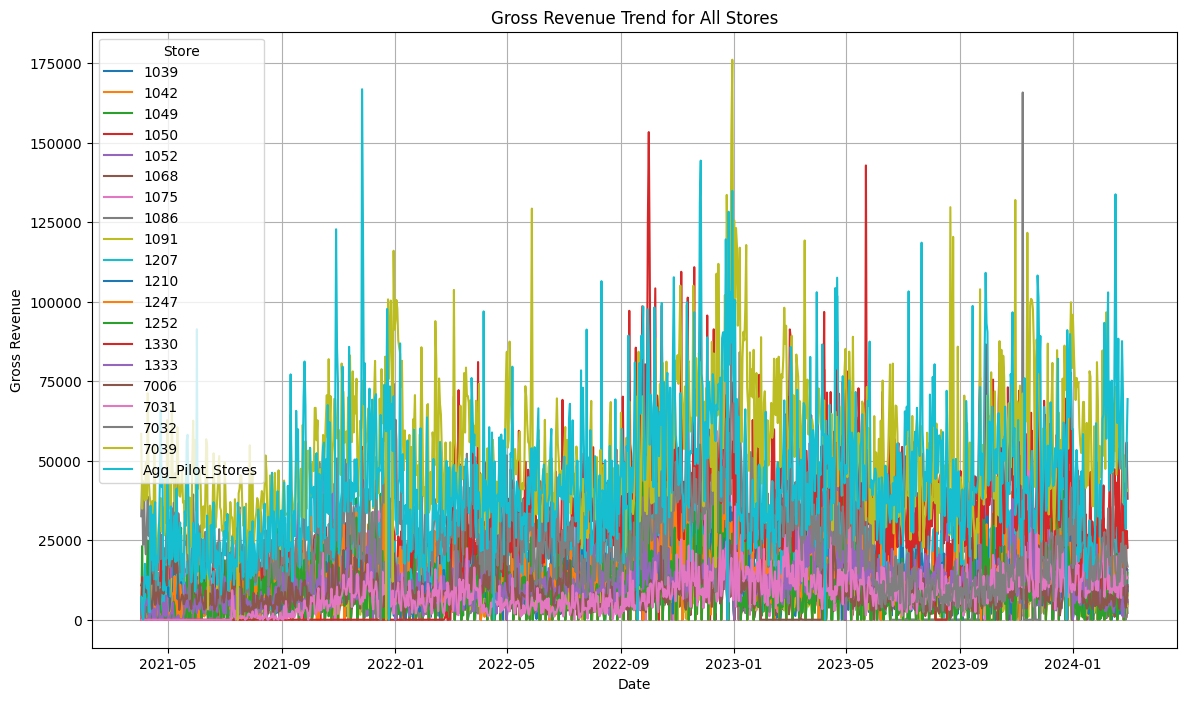

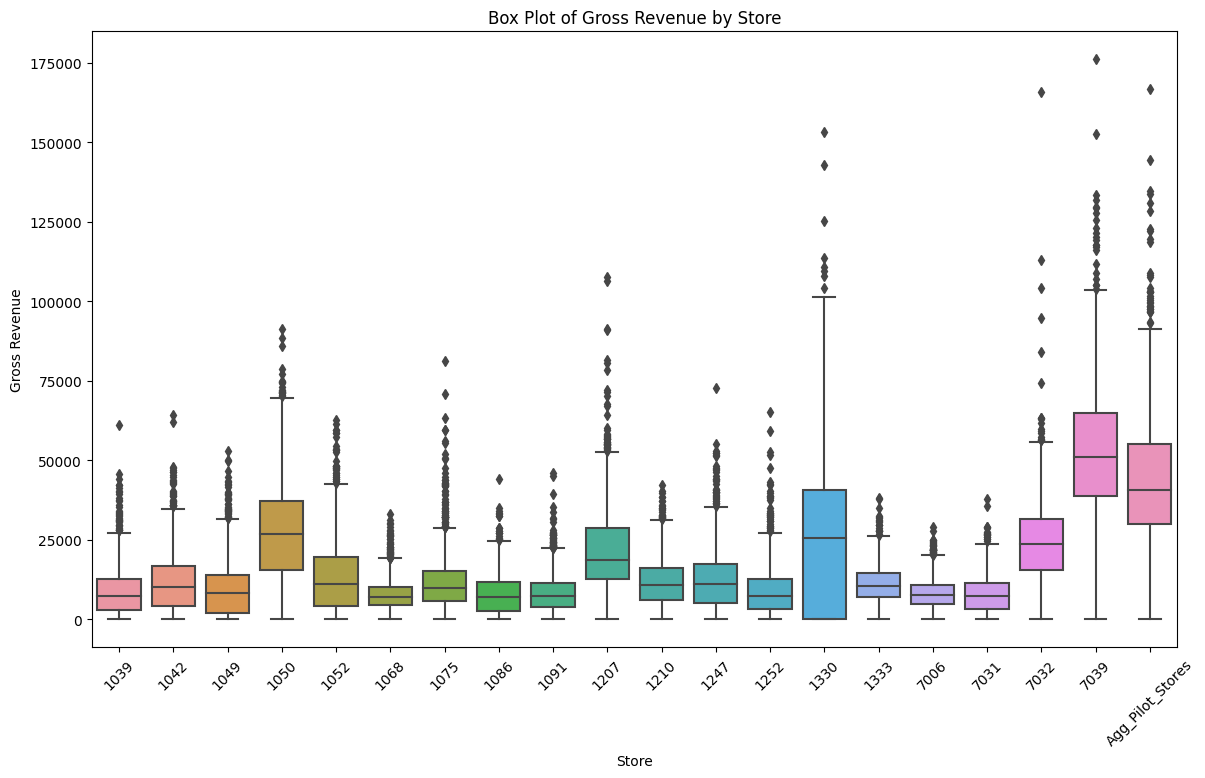

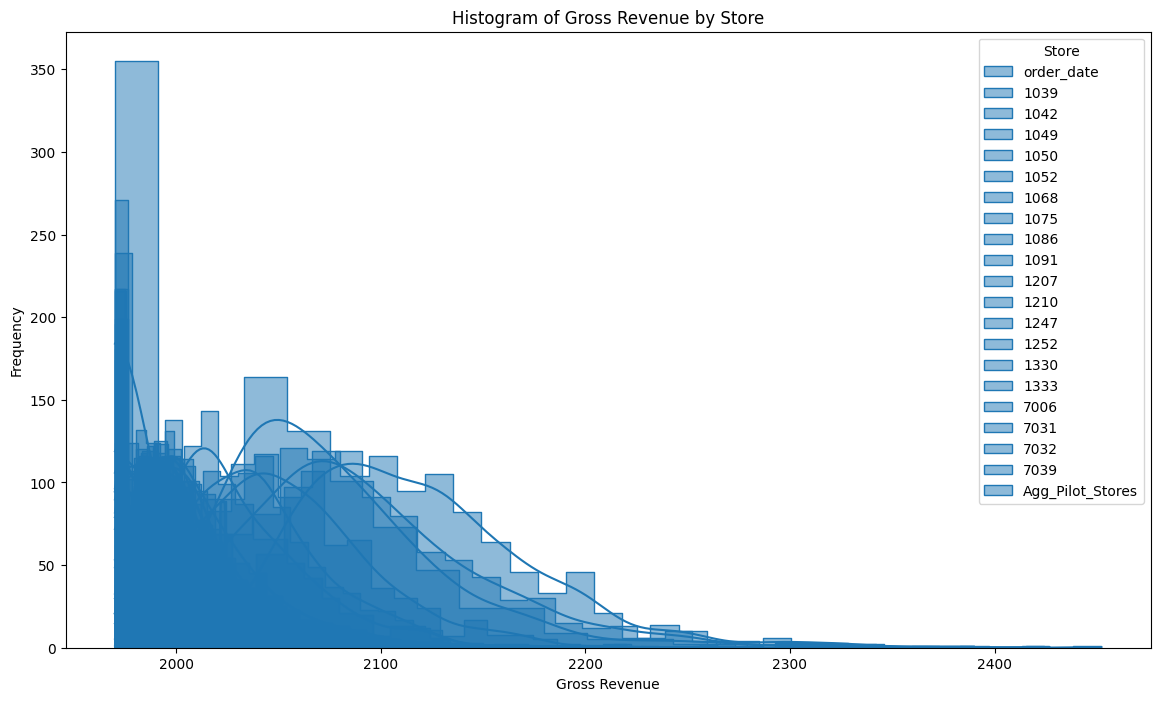

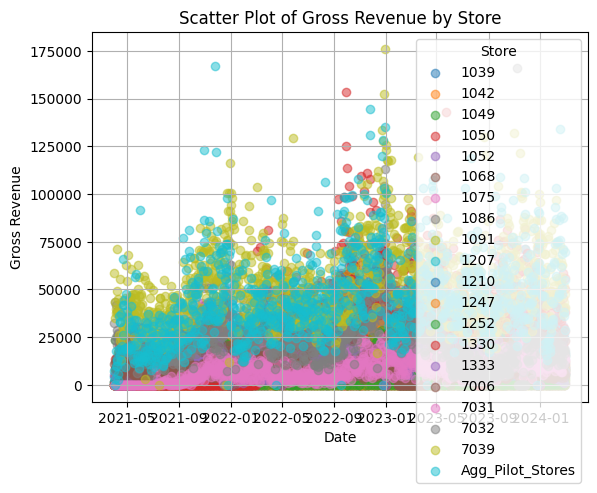

In [0]:
domain_df.index = pd.to_datetime(domain_df[get_date_column])
print(domain_df.index)  # Check the index
print(domain_df.columns)  # Check the columns

domain_df_stats = domain_df[1:] # Slice out the first row

# Print basic information about the dataset
print(domain_df_stats.info())
print(domain_df_stats.head())

# 1. Plot the revenue trends for all stores (Line Plot)
plt.figure(figsize=(14, 8))
for store in domain_df_stats.columns:
  if store != get_date_column:
    plt.plot(domain_df_stats.index, domain_df_stats[store], label=store)
plt.title('Gross Revenue Trend for All Stores')
plt.xlabel('Date')
plt.ylabel('Gross Revenue')
plt.legend(title='Store')
plt.grid(True)
plt.show()

# 2. Plot the revenue distribution for each store (Box Plot)
# Melt the DataFrame to long format for seaborn's boxplot
data_melted = domain_df_stats.melt(id_vars=get_date_column, var_name='Store', value_name='Gross Revenue')

# Create the Box Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Store', y='Gross Revenue', data=data_melted)
plt.title('Box Plot of Gross Revenue by Store')
plt.xlabel('Store')
plt.ylabel('Gross Revenue')
plt.xticks(rotation=45)
plt.show()

# 3. Plot the distribution of revenue (Histogram)
plt.figure(figsize=(14, 8))
for store in domain_df_stats.columns:
    sns.histplot(domain_df_stats[store], kde=True, label=store, element='step')
plt.title('Histogram of Gross Revenue by Store')
plt.xlabel('Gross Revenue')
plt.ylabel('Frequency')
plt.legend(title='Store')
plt.show()

# 4. Plot the revenue data for each store (Scatter Plot)
for store in domain_df_stats.columns:
    if store != get_date_column:  # Skip the date column
        plt.scatter(domain_df_stats[get_date_column], domain_df_stats[store], alpha=0.5, label=store)

plt.title('Scatter Plot of Gross Revenue by Store')
plt.xlabel('Date')
plt.ylabel('Gross Revenue')
plt.legend(title='Store')
plt.grid(True)
plt.show()

In [0]:
stats_treated_std = treated_data_std.describe()
print(stats_treated_std)
stats_control_std = control_data_std.describe()
print(stats_control_std)

count   1065.0
mean       0.0
std        1.0
min       -2.0
25%       -0.7
50%       -0.2
75%        0.5
max        5.6
Name: Agg_Pilot_Stores, dtype: float64
        1039   1042   1049   1050   1052   1068   1075   1086   1091   1207  \
count 1065.0 1065.0 1065.0 1065.0 1065.0 1065.0 1065.0 1065.0 1065.0 1065.0   
mean    -0.0   -0.0   -0.0    0.0    0.0   -0.0   -0.0    0.0    0.0   -0.0   
std      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
min     -1.1   -1.2   -1.1   -1.6   -1.1   -1.5   -1.3   -1.2   -1.3   -1.6   
25%     -0.7   -0.8   -0.8   -0.7   -0.8   -0.7   -0.6   -0.8   -0.7   -0.7   
50%     -0.2   -0.1   -0.2   -0.0   -0.2   -0.2   -0.2   -0.1   -0.1   -0.2   
75%      0.5    0.5    0.4    0.6    0.5    0.5    0.3    0.6    0.5    0.5   
max      6.4    5.4    4.7    3.7    4.1    4.9    7.2    5.7    5.8    6.2   

        1210   1247   1252   1330   1333   7006   7031   7032   7039  
count 1065.0 1065.0 1065.0 1065.0 1065.0 1065.0 1065.0 106

In [0]:
display(treated_data_std)
display(control_data_std)

order_date
2021-04-01   -1.4
2021-04-02   -1.7
2021-04-03   -1.9
2021-04-04   -2.0
2021-04-05   -1.6
2021-04-06   -1.2
2021-04-07   -1.5
2021-04-08   -1.6
2021-04-09   -1.4
2021-04-10   -1.8
2021-04-11   -1.9
2021-04-12   -0.4
2021-04-13   -1.2
2021-04-14   -0.5
2021-04-15   -1.3
2021-04-16   -0.5
2021-04-17   -0.3
2021-04-18   -1.5
2021-04-19   -1.1
2021-04-20   -1.2
2021-04-21   -0.8
2021-04-22   -0.1
2021-04-23    1.0
2021-04-24   -0.1
2021-04-25   -0.0
2021-04-26   -1.6
2021-04-27   -1.2
2021-04-28   -1.1
2021-04-29   -1.2
2021-04-30    0.1
2021-05-01   -0.3
2021-05-02   -1.2
2021-05-03   -1.2
2021-05-04   -0.4
2021-05-05   -1.2
2021-05-06   -1.1
2021-05-07   -0.7
2021-05-08   -0.5
2021-05-09   -1.2
2021-05-10   -0.1
2021-05-11   -1.1
2021-05-12   -1.2
2021-05-13   -0.7
2021-05-14   -0.6
2021-05-15   -1.2
2021-05-16   -1.4
2021-05-17   -1.1
2021-05-18   -1.5
2021-05-19   -0.5
2021-05-20   -0.7
2021-05-21    0.6
2021-05-22    0.6
2021-05-23   -0.5
2021-05-24   -1.0
2021-05-25   -1.3

1039 1042 1049 1050 1052 1068 1075 1086 1091 1207 1210 1247 1252 1330 1333 7006 7031 7032 7039 -0.23558890932584337 -1.0573490595880906 -0.1849689428425846 -0.7907633926186519 -1.111499217903662 -1.5392333551755768 -0.9835215909678419 -0.48481704232756156 0.056815817153812884 -1.0635955713435195 -1.1851447820477354 -1.0179606422690133 0.41604431454087887 -1.0828208543033138 -1.1904322149974 0.5069206056382703 -1.3122646233681021 0.9689171906374556 -0.5832418909566559 -1.0854498824996877 -1.171068410861475 -1.0588748690789753 -1.5782096513053026 -1.111499217903662 -1.5392333551755768 -1.258618942852929 -1.0156149621025259 -0.998904361848532 -1.292941551740843 -1.2815948230828023 -1.2014081392029563 -1.0646109205901695 -1.0828208543033138 -1.018590371419087 0.4941114418873565 -1.3122646233681021 0.5561365915847984 0.22266175096095772 -0.10698438765194895 -0.6812695201815152 1.4496521249280023 -0.8022437594642788 -1.111499217903662 -1.5392333551755768 -1.258618942852929 -1.2325802428185886 -0.19731443031564955 -1.5645096348138334 -0.9268558671622581 -0.7465586265949972 -0.9983737964498702 -1.0828208543033138 -1.82147849796398 0.6786250216430874 -1.3122646233681021 1.3447190181827824 -0.9202658966935804 -1.0854498824996877 -1.171068410861475 -1.0588748690789753 -1.5782096513053026 -1.111499217903662 -1.5392333551755768 -1.258618942852929 -1.2325802428185886 -1.2503306058759467 -1.5645096348138334 -1.3028462217019818 -1.2014081392029563 -1.0646109205901695 -1.0828208543033138 -1.82147849796398 -0.015001629194899162 -1.3122646233681021 -0.08520881033451529 -0.4996323623368603 -1.0854498824996877 -1.171068410861475 -1.0588748690789753 -1.5782096513053026 -1.111499217903662 -1.5392333551755768 -1.258618942852929 -1.2325802428185886 -1.2503306058759467 -1.5645096348138334 -1.468500035312699 -1.2014081392029563 -1.0646109205901695 -1.0828208543033138 -1.82147849796398 0.11147631099456855 -1.3122646233681021 1.1972434916468906 -0.6824304537611215 -0.4488575735187367 -1.171068410861475 -0.25488103175628857 -1.0178669118248105 -1.111499217903662 -1.5392333551755768 -0.8155259424859331 -0.2861979506406232 -0.5960818172772385 -0.9761292626265834 -0.9649996739267559 -0.7733636932094827 -1.0646109205901695 -1.0828208543033138 -1.1167862044708494 1.0720670999600335 -1.3122646233681021 0.00927280174206292 -0.795003363533367 -0.8357429772798844 -0.8514005726877707 -0.6593748377855015 -0.780799880898457 -0.6192458898512588 -1.4368166609194826 -0.9276424413661837 -1.2325802428185886 -1.0232357698085979 -1.2941087519649048 -1.296307176907333 -1.1260187699826574 -0.5724179024661145 -1.0828208543033138 -1.0301436648404996 0.6121837606106248 -1.3122646233681021 -0.2987373691697497 -0.2184090247719747 -0.9782795699461532 -0.7555898875718373 0.2977604149176599 -0.9106603427202232 -1.111499217903662 -1.5392333551755768 -1.0902650946940868 -1.1240973676423622 -1.0678438904208614 -1.226610875686019 -1.1077669549970601 -0.8830971614599438 -0.6875686148619028 -1.0828208543033138 -0.7817690101280937 0.0174184285868997 -1.3122646233681021 0.28391760413468964 -0.7719037194919436 -0.3138231189804539 -0.8827407129435193 1.6369180283296672 -0.993633147851745 -1.111499217903662 -1.5392333551755768 -1.2227989751595585 -0.1721350124241119 -0.6055440571673663 -1.267791232604307 -1.255983688544619 -0.7675000968242699 -0.8118906177949564 -1.0828208543033138 -0.7976546445388247 0.5541481210443625 -1.3122646233681021 0.9930590846717111 0.842382048158542 -0.5828209223658208 -0.33294816322504117 0.8029612179982704 -1.3196392072368415 -1.111499217903662 -1.5392333551755768 -1.258618942852929 -1.2325802428185886 -0.21623829369345618 -1.5645096348138334 -1.1600786921499633 -0.8353505291225389 -0.22288993303053298 -1.0828208543033138 -1.82147849796398 0.6301952742766656 -1.3122646233681021 0.12045952894967424 -0.42803905956196964 -1.0854498824996877 -1.171068410861475 -0.8882550257272299 -1.5782096513053026 -1.111499217903662 -1.4484110036654554 -1.258618942852929 -1.23258024281

In [0]:
# Concatenate the two dataframes
combined_data = pd.concat([treated_data_std, control_data_std], axis=0)
combined_data = combined_data.reset_index()
combined_data = combined_data.rename(columns={combined_data.columns[1]: 'Treated'})

# Melt the combined dataframe to long format
combined_melted = combined_data.melt(id_vars=[get_date_column], var_name='Store', value_name='Gross Revenue')
treated_data_std.head()

order_date
2021-04-01   -1.4
2021-04-02   -1.7
2021-04-03   -1.9
2021-04-04   -2.0
2021-04-05   -1.6
Name: Agg_Pilot_Stores, dtype: float64

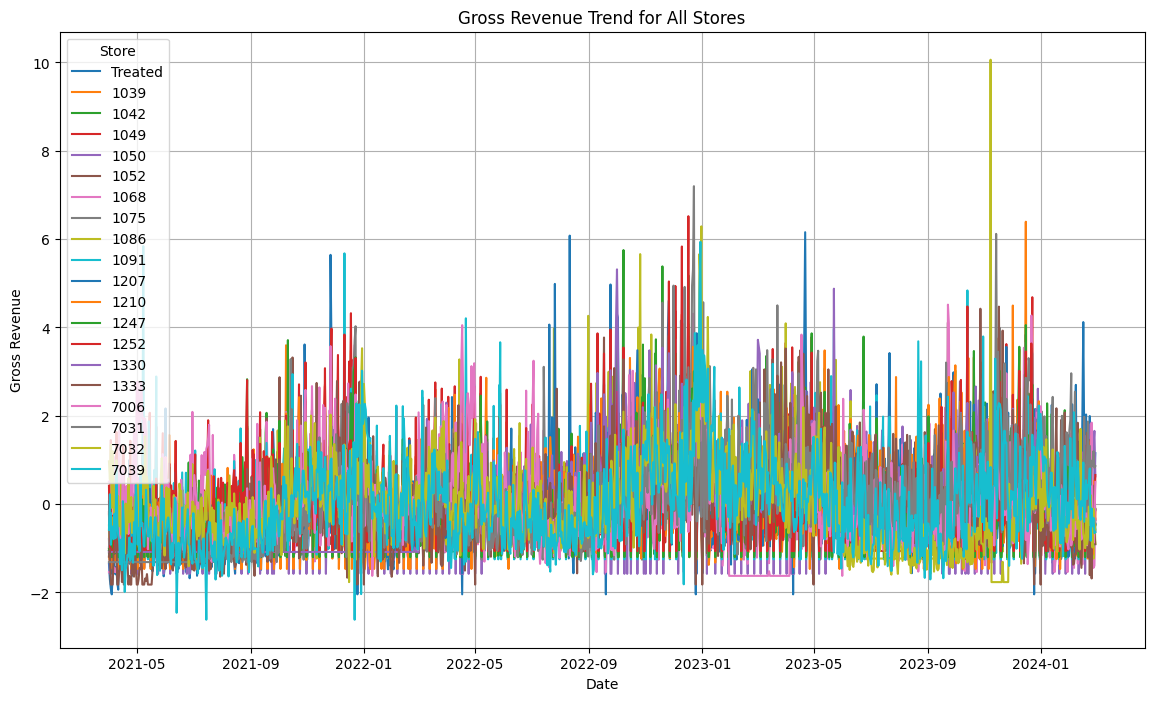

In [0]:
# 1. Plot the revenue trends for all stores (Line Plot)
plt.figure(figsize=(14, 8))
for store in combined_melted['Store'].unique():
    store_data = combined_melted[combined_melted['Store'] == store]
    plt.plot(store_data[get_date_column], store_data['Gross Revenue'], label=store)
plt.title('Gross Revenue Trend for All Stores')
plt.xlabel('Date')
plt.ylabel('Gross Revenue')
plt.legend(title='Store')
plt.grid(True)
plt.show()


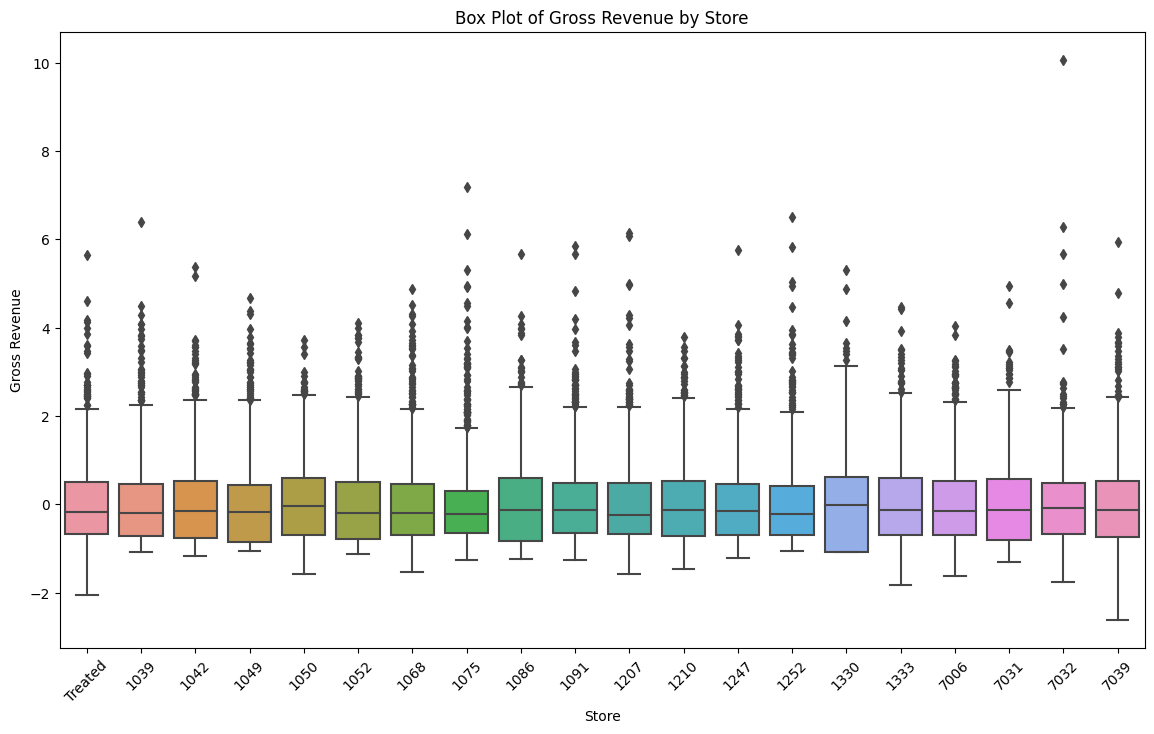

In [0]:

# 2. Plot the revenue distribution for each store (Box Plot)
plt.figure(figsize=(14, 8))
sns.boxplot(x='Store', y='Gross Revenue', data=combined_melted)
plt.title('Box Plot of Gross Revenue by Store')
plt.xlabel('Store')
plt.ylabel('Gross Revenue')
plt.xticks(rotation=45)
plt.show()

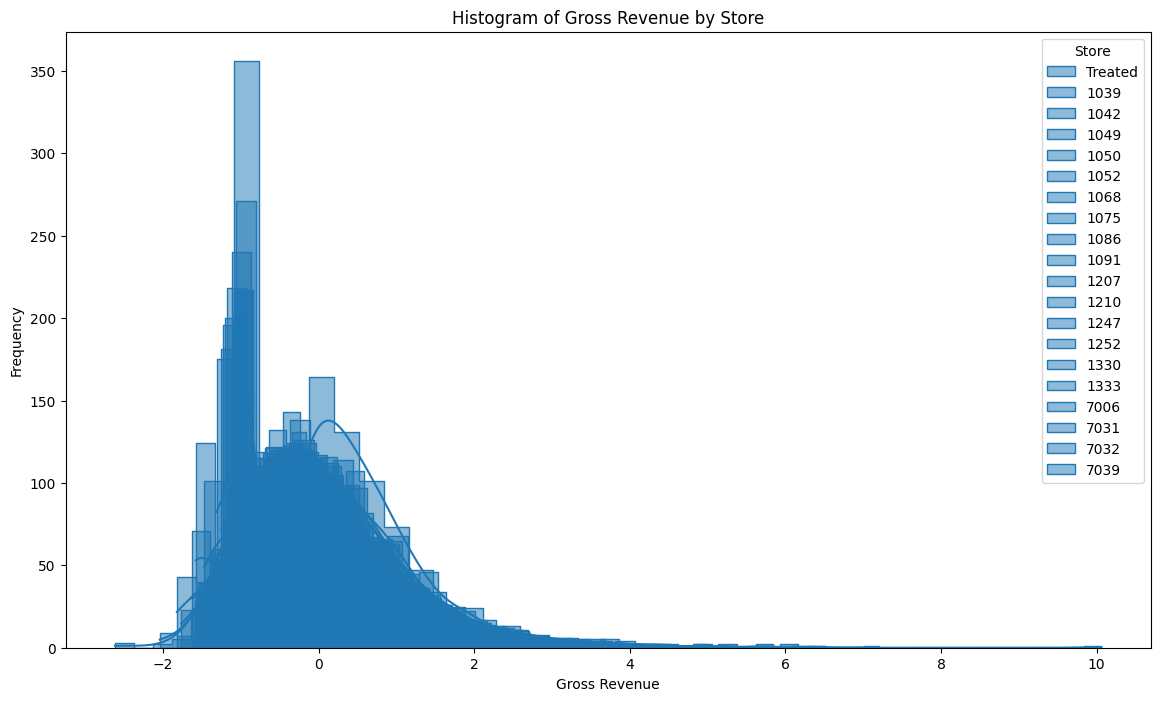

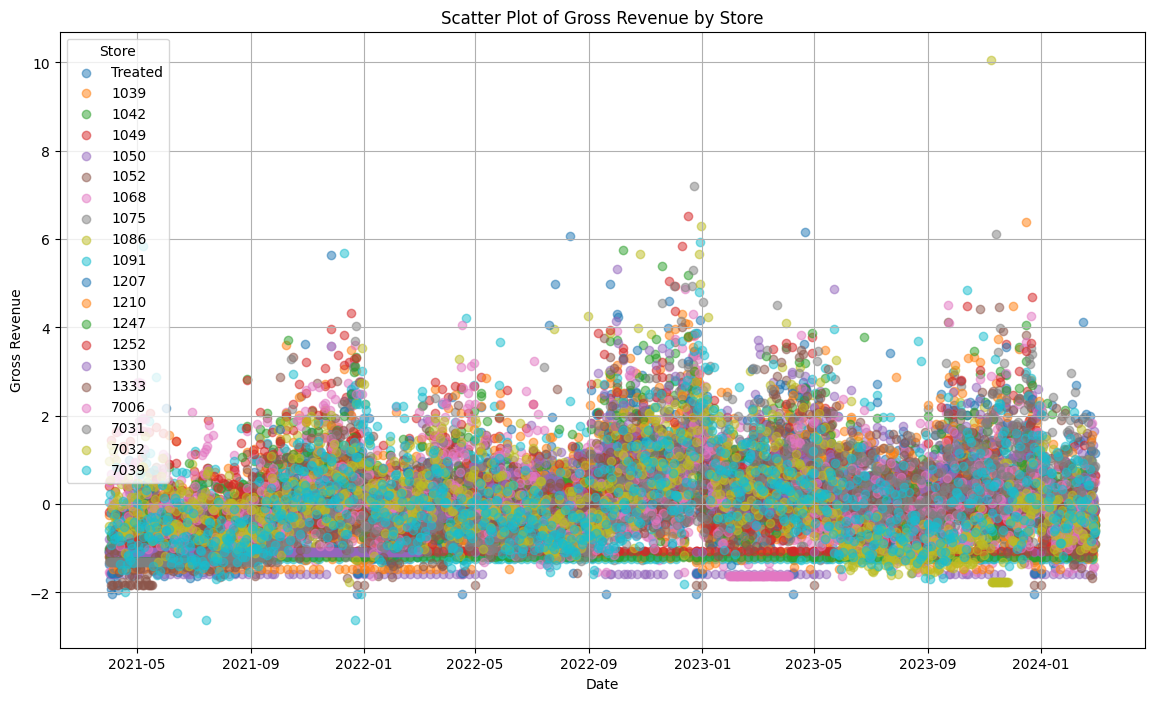

In [0]:
# 3. Plot the distribution of revenue (Histogram)
plt.figure(figsize=(14, 8))
for store in combined_melted['Store'].unique():
    store_data = combined_melted[combined_melted['Store'] == store]
    sns.histplot(store_data['Gross Revenue'], kde=True, label=store, element='step')
plt.title('Histogram of Gross Revenue by Store')
plt.xlabel('Gross Revenue')
plt.ylabel('Frequency')
plt.legend(title='Store')
plt.show()

# 4. Plot the revenue data for each store (Scatter Plot)
plt.figure(figsize=(14, 8))
for store in combined_melted['Store'].unique():
    store_data = combined_melted[combined_melted['Store'] == store]
    plt.scatter(store_data[get_date_column], store_data['Gross Revenue'], alpha=0.5, label=store)
plt.title('Scatter Plot of Gross Revenue by Store')
plt.xlabel('Date')
plt.ylabel('Gross Revenue')
plt.legend(title='Store')
plt.grid(True)
plt.show()

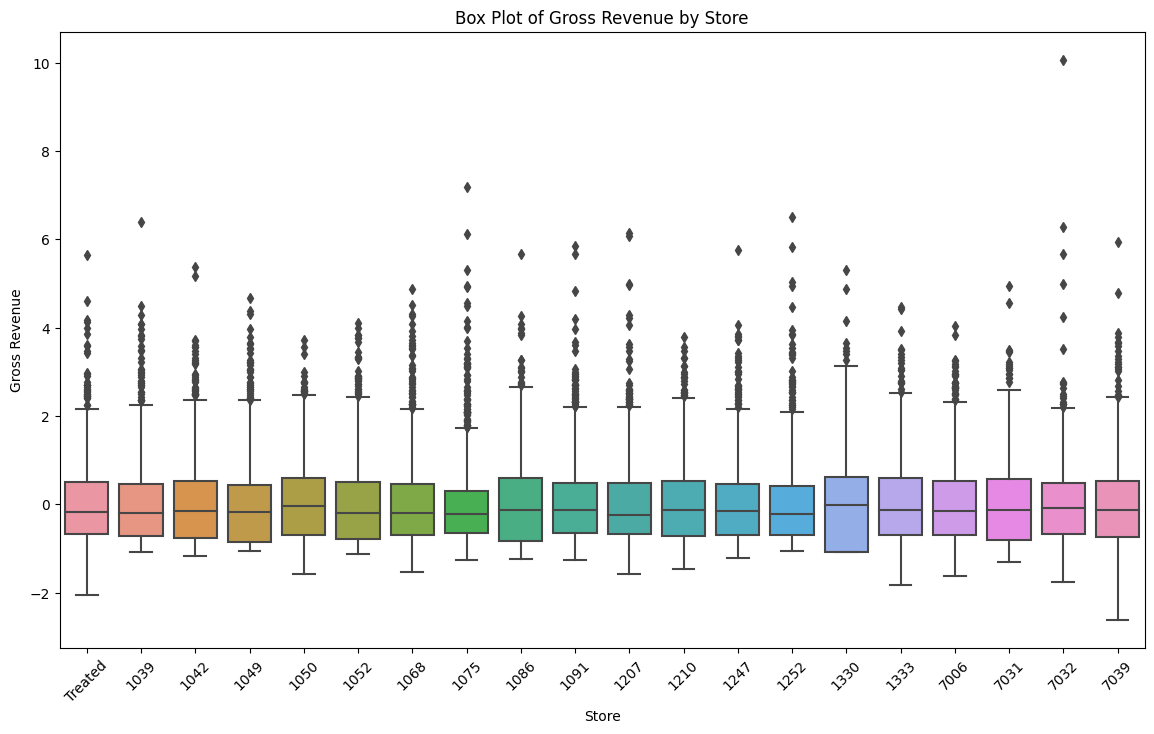

In [0]:
# 2. Plot the revenue distribution for each store (Box Plot)
plt.figure(figsize=(14, 8))
sns.boxplot(x='Store', y='Gross Revenue', data=combined_melted)
plt.title('Box Plot of Gross Revenue by Store')
plt.xlabel('Store')
plt.ylabel('Gross Revenue')
plt.xticks(rotation=45)
plt.show()

In [0]:
standardized_stats = combined_data.describe()
markdown_table_standardized = tabulate(standardized_stats, headers='keys', tablefmt='github')
print(markdown_table_standardized)

|       |        Treated |           1039 |           1042 |           1049 |           1050 |        1052 |           1068 |        1075 |           1086 |           1091 |           1207 |           1210 |           1247 |           1252 |           1330 |        1333 |           7006 |           7031 |           7032 |           7039 |
|-------|----------------|----------------|----------------|----------------|----------------|-------------|----------------|-------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|-------------|----------------|----------------|----------------|----------------|
| count | 1065           | 1065           | 1065           | 1065           | 1065           | 1065        | 1065           | 1065        | 1065           | 1065           | 1065           | 1065           | 1065           | 1065           | 1065           | 1065        | 1065           | 1065           | 1065       

In [0]:
def generate_initial_guess(control_data_columns, initial_guess_stores, num_best_stores):
    initial_guess_indices = [control_data_columns.index(store) for store in initial_guess_stores if store in control_data_columns]
    all_store_indices = list(range(len(control_data_columns)))

    if num_best_stores <= len(initial_guess_indices):
        return initial_guess_indices[:num_best_stores]
    else:
        additional_stores_needed = num_best_stores - len(initial_guess_indices)
        available_stores = list(set(all_store_indices) - set(initial_guess_indices))
        additional_stores = random.sample(available_stores, additional_stores_needed)
        return initial_guess_indices + additional_stores

def synth_control_weights(X, y, store_indices, initial_guess_indices, num_best_stores):
    def objective(weights, X, y):
        return np.sum((y - np.dot(X, weights))**2)
    
    initial_guess_indices = generate_initial_guess(store_indices, initial_guess_indices, num_best_stores)

    initial_guess = np.zeros(len(store_indices))
    num_interest_stores = len(initial_guess_indices)
    for idx, store_idx in enumerate(initial_guess_indices):
        if store_idx in store_indices:
            initial_guess[store_indices.index(store_idx)] = 1.0 / num_interest_stores

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(len(store_indices))]

    result = minimize(objective, initial_guess, args=(X[:, store_indices], y), constraints=constraints, bounds=bounds)

    if not result.success:
        raise ValueError("Optimization failed with message: " + result.message)

    # Adjust weights to ensure only num_best_stores weights are non-zero
    sorted_indices = np.argsort(result.x)[::-1]  # Sort weights in descending order
    adjusted_weights = np.zeros_like(result.x)
    adjusted_weights[sorted_indices[:num_best_stores]] = result.x[sorted_indices[:num_best_stores]]
    adjusted_weights /= np.sum(adjusted_weights)  # Normalize to sum to 1

    best_stores = np.array(store_indices)[sorted_indices[:num_best_stores]].tolist()

    # Ensure the order of weights corresponds to the order of best_stores
    best_stores_weights = adjusted_weights[sorted_indices[:num_best_stores]]

    return best_stores, best_stores_weights, np.sum((y - np.dot(X[:, store_indices], adjusted_weights))**2)

def find_best_stores(X, y, control_data_columns, initial_guess_stores, num_best_stores):
    min_sse = float('inf')
    best_stores = None
    best_weights = None

    initial_guess_indices = [control_data_columns.index(store) for store in initial_guess_stores if store in control_data_columns]
    all_stores_indices = list(range(len(control_data_columns)))

    candidate_store_indices = initial_guess_indices[:num_best_stores]

    try:
        selected_store_indices, weights, sse = synth_control_weights(X, y, all_stores_indices, candidate_store_indices, num_best_stores)
        if sse < min_sse:
            min_sse = sse
            best_stores = selected_store_indices
            best_weights = weights
    except ValueError as e:
        print(f"Optimization failed for combination {candidate_store_indices} with error: {e}")

    if best_stores is None:
        raise ValueError("No valid store combination found")

    return best_stores, best_weights, min_sse

def rolling_window_cv(X_full, y_full, control_data_columns, initial_guess_stores, min_stores=1, max_stores=10, train_start_idx=None, train_end_idx=None, test_start_idx=None, test_end_idx=None):
    sse_scores = []
    sse_scores_train = []
    test_periods = []
    test_sse_over_time = []
    best_store_combinations = []

    if train_start_idx is None or train_end_idx is None or test_start_idx is None or test_end_idx is None:
        raise ValueError("train_start_idx, train_end_idx, test_start_idx, and test_end_idx must be provided.")

    for n_stores in range(min_stores, max_stores + 1):
        sse_list = 0
        sse_scores_per_window = []
        sse_train_per_window = []
        best_stores_for_n = []
        valid_combination = True

        current_test_start_idx = test_start_idx
        current_train_end_idx = train_end_idx

        while current_test_start_idx < test_end_idx:
            current_test_end_idx = min(current_test_start_idx + 30, test_end_idx)
            current_test_start = dataset_start_date + pd.Timedelta(days=current_test_start_idx)
            current_test_end = dataset_start_date + pd.Timedelta(days=current_test_end_idx)
            if n_stores == min_stores:  # Only recore test periods once
                test_periods.append(current_test_start)
            
            # Training set: fixed start index, end index rolls with test set
            X_train = X_full[train_start_idx:current_train_end_idx]
            y_train = y_full[train_start_idx:current_train_end_idx]
            X_test = X_full[current_test_start_idx:current_test_end_idx]
            y_test = y_full[current_test_start_idx:current_test_end_idx]

            initial_guess_indices = generate_initial_guess(control_data_columns, initial_guess_stores, n_stores)

            try:
                best_stores, best_weights, sse_window = find_best_stores(X_train, y_train, control_data_columns, initial_guess_stores, num_best_stores=n_stores)
                y_pred = np.dot(X_test[:, best_stores], best_weights)
                sse_test_window = np.sum((y_test - y_pred)**2)
                sse_train_window = sse_window
                sse_scores_per_window.append(sse_test_window)
                sse_train_per_window.append(sse_window)
                best_stores_for_n = best_stores

                print(f"Completed window from {current_test_start} to {current_test_end} with n_stores={n_stores}, SSE={sse_test_window}")
            except ValueError as e:
                print(f"Optimization failed for n_stores={n_stores} with error: {e}")
                valid_combination = False
                break

            # Rolling window: only test set rolls forward by 30 days
            current_test_start_idx += 30
            current_train_end_idx += 30
                    
        if valid_combination:
            average_sse = np.mean(sse_scores_per_window) if sse_scores_per_window else np.nan
            average_sse_train = np.mean(sse_train_per_window) if sse_train_per_window else np.nan
            sse_scores.append(average_sse)
            sse_scores_train.append(average_sse_train)
            best_store_combinations.append(best_stores_for_n)
            test_sse_over_time.append(sse_scores_per_window)
        else:
            sse_scores.append(np.nan)
            test_sse_over_time.append(np.nan)
        print(f'Number of stores: {n_stores}, average SSE:{average_sse}')

    plt.figure(figsize=(12, 8))
    for i, sse_scores_ in enumerate(test_sse_over_time):
        plt.plot(test_periods, sse_scores_, marker='o', linestyle='-', label=f'n_stores={i+1}')

    plt.title('SSE Scores Across Different Expanding Windows')
    plt.xlabel('Test Window Start Date')
    plt.ylabel('SSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    valid_indices = [i for i in range(min_stores, max_stores + 1) if not np.isnan(sse_scores[i - min_stores])]
    valid_sse_scores = [sse_scores[i - min_stores] for i in valid_indices]
    plt.figure(figsize=(10, 6))
    plt.plot(valid_indices, valid_sse_scores, marker='o', linestyle='-')
    plt.gca().invert_xaxis()
    plt.title('Average SSE Scores with Different Number of Control Stores')
    plt.xlabel('Number of Control Stores')
    plt.ylabel('Average Sum of Squared Errors (SSE)')
    plt.grid(True)
    plt.show()

    valid_indices_train = [i for i in range(min_stores, max_stores + 1) if not np.isnan(sse_scores_train[i - min_stores])]
    valid_sse_scores_train = [sse_scores_train[i - min_stores] for i in valid_indices_train]
    plt.figure(figsize=(10, 6))
    plt.plot(valid_indices_train, valid_sse_scores_train, marker='o', linestyle='-')
    plt.gca().invert_xaxis()
    plt.title('Average Training SSE Scores with Different Number of Control Stores')
    plt.xlabel('Number of Control Stores')
    plt.ylabel('Average Sum of Squared Errors (SSE)')
    plt.grid(True)
    plt.show()

    return best_store_combinations, sse_scores

In [0]:
dataset_start_date = domain_df[get_date_column].min()
train_start_idx = (get_train_start_rolling_window - dataset_start_date).days
train_end_idx = (get_train_end_rolling_window - dataset_start_date).days
test_start_idx = (get_test_start_rolling_window - dataset_start_date).days
test_end_idx = (get_test_end_rolling_window - dataset_start_date).days
print(train_start_idx, train_end_idx, test_start_idx, test_end_idx)

initial_guess_stores = ['1068', '1333', '1050', '1210', '1207', '7006']

X_full = control_data_std.values
y_full = treated_data_std.values

control_data_pre_treatment = control_data_std[control_data_std.index < get_treatment_start]
treated_data_pre_treatment = treated_data_std[treated_data_std.index < get_treatment_start]
control_data_during_treatment = control_data_std[(control_data_std.index >= get_treatment_start) & (control_data_std.index <= get_treatment_end)]
treated_data_during_treatment = treated_data_std[(treated_data_std.index >= get_treatment_start) & (treated_data_std.index <= get_treatment_end)]
X_pre_treatment = control_data_pre_treatment.values
y_pre_treatment = treated_data_pre_treatment.values
X_treatment = control_data_during_treatment.values
y_treatment = treated_data_during_treatment.values

control_data_columns = control_data_std.columns.tolist()

0 851 852 1035


Completed window from 2023-08-01 00:00:00 to 2023-08-31 00:00:00 with n_stores=1, SSE=33.92195854023274
Completed window from 2023-08-31 00:00:00 to 2023-09-30 00:00:00 with n_stores=1, SSE=81.97041722128145
Completed window from 2023-09-30 00:00:00 to 2023-10-30 00:00:00 with n_stores=1, SSE=29.632782761015726
Completed window from 2023-10-30 00:00:00 to 2023-11-29 00:00:00 with n_stores=1, SSE=48.15155957906885
Completed window from 2023-11-29 00:00:00 to 2023-12-29 00:00:00 with n_stores=1, SSE=52.64420558356116
Completed window from 2023-12-29 00:00:00 to 2024-01-28 00:00:00 with n_stores=1, SSE=26.67763537862281
Completed window from 2024-01-28 00:00:00 to 2024-01-31 00:00:00 with n_stores=1, SSE=1.663220289637065
Number of stores: 1, average SSE:39.237397050488546
Completed window from 2023-08-01 00:00:00 to 2023-08-31 00:00:00 with n_stores=2, SSE=21.51143299995735
Completed window from 2023-08-31 00:00:00 to 2023-09-30 00:00:00 with n_stores=2, SSE=49.71850668262278
Completed w

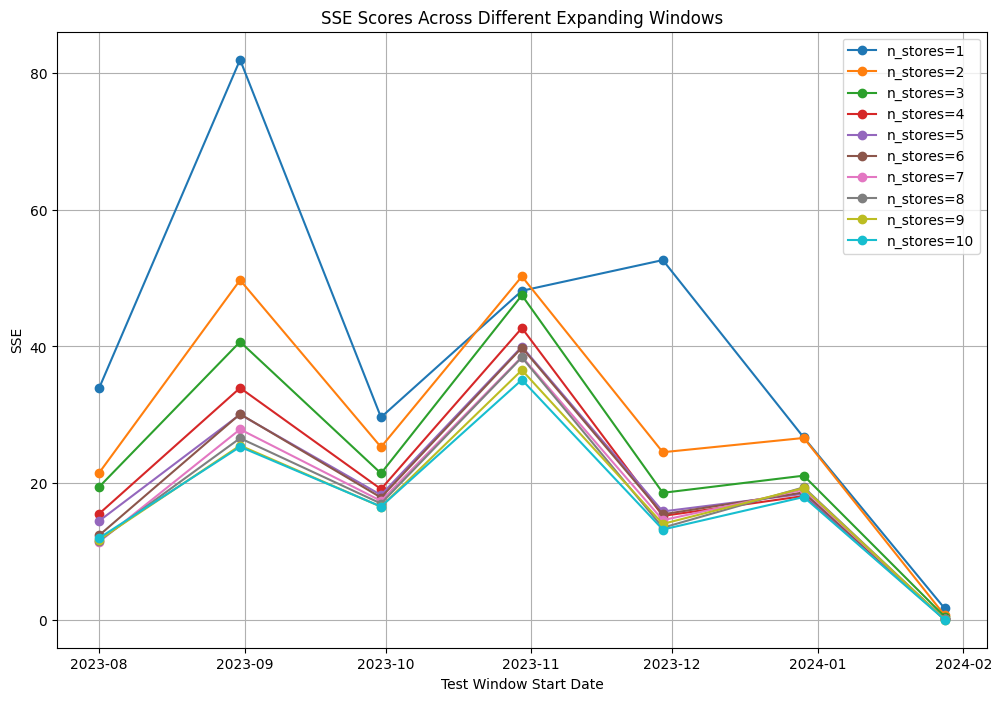

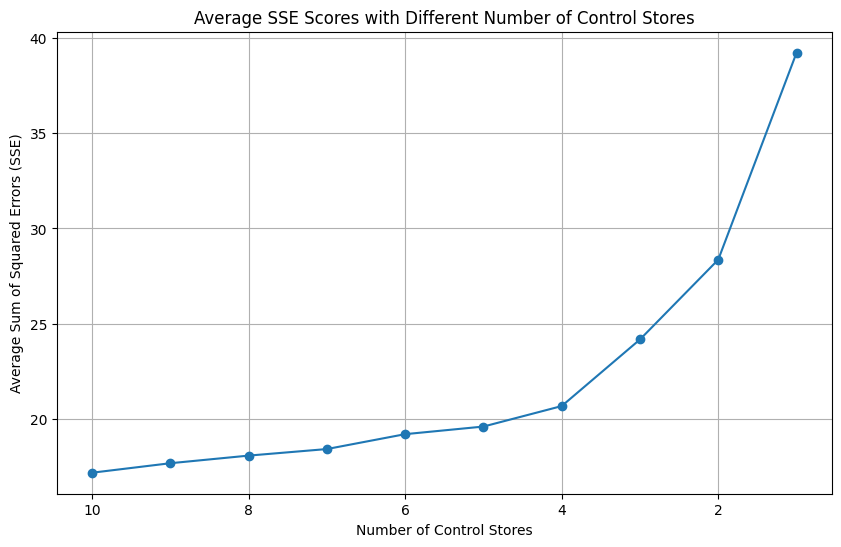

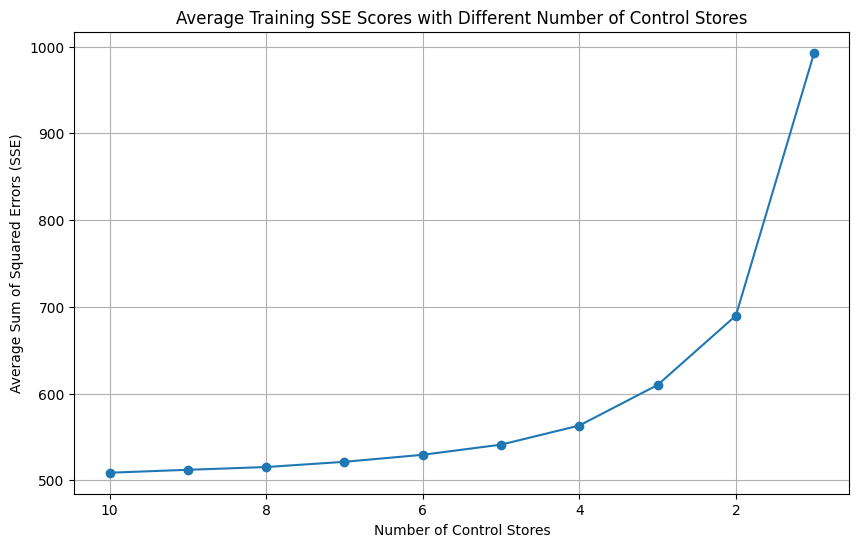

In [0]:
best_store_combinations, sse_scores = rolling_window_cv(X_full, y_full, control_data_columns, initial_guess_stores, 1, 10, train_start_idx, train_end_idx, test_start_idx, test_end_idx)

Final sse for the synthetic group of 4 in the treatment period (1 month) is 84.82684526034205 (with a train sse of 634.8998700675088 (38 months) and an average train sse of 16.70789131756602 (per month)).


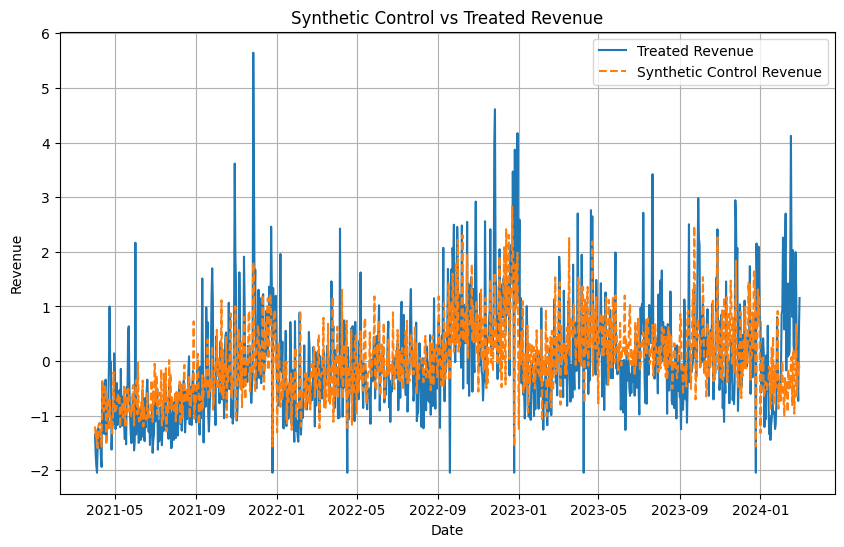

In [0]:
# Considering the elbow method, use 4 as the best number of stores combination
optimal_n = 4
initial_guess_n = generate_initial_guess(control_data_columns, initial_guess_stores, optimal_n)

# Perform final optimization with the fixed number of best stores (optimal_n)
best_stores_final, weights, sse_final_train = synth_control_weights(
    X_pre_treatment, y_pre_treatment, initial_guess_n,
    [control_data_columns.index(store) for store in initial_guess_stores if store in control_data_columns],
    num_best_stores=optimal_n  # Force the number of best stores to be optimal_n
)
y_pred_final = np.dot(X_treatment[:, best_stores_final], weights)
sse_final_treatment = np.sum((y_treatment - y_pred_final)**2)
print(f"Final sse for the synthetic group of {optimal_n} in the treatment period (1 month) is {sse_final_treatment} (with a train sse of {sse_final_train} (38 months) and an average train sse of {sse_final_train/38} (per month))." )

# Calculate synthetic control revenue using the final best stores and weights
synthetic_control_revenue_std = np.dot(X_full[:, best_stores_final], weights)

# Create synthetic control dataframe
synthetic_control_df = pd.DataFrame({'order_date': treated_data.index, 'synthetic_revenue': synthetic_control_revenue_std})
synthetic_control_df.set_index('order_date', inplace=True)

# Combine treated and synthetic control revenue data
all_results_data = pd.DataFrame({
    'treated_revenue': treated_data_std,
    'synthetic_revenue': synthetic_control_df['synthetic_revenue']
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(all_results_data.index, all_results_data['treated_revenue'], label='Treated Revenue')
plt.plot(all_results_data.index, all_results_data['synthetic_revenue'], label='Synthetic Control Revenue', linestyle='--')
plt.title('Synthetic Control vs Treated Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

In [0]:
final_stats = all_results_data.describe()
print(final_stats)

       treated_revenue  synthetic_revenue
count           1065.0             1065.0
mean               0.0                0.0
std                1.0                0.7
min               -2.0               -1.6
25%               -0.7               -0.5
50%               -0.2               -0.1
75%                0.5                0.4
max                5.6                2.8


In [0]:
display(all_results_data)

treated_revenue synthetic_revenue -1.3503208471997183 -1.1953609362727804 -1.7093612216115694 -1.393194006157715 -1.9114592600482951 -1.272908684077449 -2.042705213785859 -1.5586334810735913 -1.5793600083689123 -1.5921180016122694 -1.2333018811395051 -1.1974609418603221 -1.4655740507443962 -1.1494887187556155 -1.588503921797262 -1.1301043908906114 -1.4166491155924466 -1.185678020327852 -1.7816874623372674 -1.4598900954361143 -1.9366581146269009 -1.562429556077507 -0.39143118335620414 -0.36535340973056907 -1.175604335608389 -0.7280599436013836 -0.5195334993671795 -0.9238832702611757 -1.3323826717255625 -0.7144499832967024 -0.5331003415488968 -0.46428893962171613 -0.3390290826766616 -0.5439540084147566 -1.462187177273429 -1.5314777724348825 -1.1176308464960556 -0.7744993592296129 -1.21312943793763 -0.699183841909489 -0.8302339943001125 -0.9580813714257336 -0.1258149864523359 -1.2655805878007604 0.998798376546878 -0.705166521440192 -0.11436862558003942 -0.8769949135514644 -0.008356076952952965 -1.1916398214199433 -1.6198758047369888 -1.1012261340213771 -1.1832722503151694 -1.3307195668594947 -1.1452219799014747 -1.117247717288337 -1.1616215050229335 -0.20244516285718597 0.14288818530585187 -0.8288937619462227 -0.258619860187962 -0.9543600744187268 -1.2426987044611575 -0.8934920279644577 -1.1618969879303924 -0.8843284622062431 -0.4021552077754978 -0.7008416936119225 -1.1674264550511786 -0.6877412645134617 -1.1253107387205519 -0.5848167149622081 -0.6659217995398217 -0.7624318639914304 -0.5341147451646574 -0.6711540185694981 -1.2084531386172017 -1.2095637772495047 -0.1429069042325081 -0.8500810626488615 -1.094362214964696 -0.9511912778430859 -1.1816156674803493 -0.7700376525664464 -0.7176711255038636 -1.0147799935825201 -0.6363152184418724 -1.0376984921079875 -1.1771766151454417 -0.46802084806296157 -1.4270792301539494 -0.9756315967299106 -1.088571545822958 -1.2216971496100533 -1.521452395604015 -0.5256779831144014 -0.47438701038074554 -0.9008557557576314 -0.6843570419991752 -0.9346512416242949 0.5570596917413709 -0.50272023316306 0.636808308060679 -0.5921849718958181 -0.4788458716872598 -0.831021749518824 -0.9944494475711619 -0.9814892237109525 -1.3442279760725402 -1.0049707755079156 -1.5006958180766246 -0.8948090510938427 -1.3278777430432191 -0.9558297283185075 -0.641962157371023 -0.47343981949107 -0.8138575028665685 -0.43526607660624644 -1.6341709721305666 -1.1808033550279773 -1.4704530465184733 -0.6280168878211826 2.1661433766915548 -0.5283220935577125 -1.3450189529155288 -0.3464619863654303 -0.906835748176524 -0.656392932916729 -0.7914226908377185 -0.9751220301450975 -1.1539268712381718 -0.02963371162961952 -1.4972582704922452 -1.057263928561304 -1.3791507323411865 -1.107147409743142 -0.8760590557325115 -1.048995663490999 -1.4442116872248514 -1.0953284388019464 -1.3500776114553399 -0.7530568836373103 -1.384231963895154 -1.0135084193040875 -0.5339525880017382 -0.35691012733707794 -1.2244408213987465 -1.1953025914192785 -1.374189275964375 -0.8539379262779115 -1.465112455638587 -1.0241230197526279 -0.6723569512694111 -1.0139034074446185 -1.2123647194988643 -1.0723305239011114 -0.559303004246822 -0.9707436651035968 -0.33911568934322084 -0.5858581095582961 -0.6810687527124826 -1.059685385355665 -1.2928485711364075 -1.008805569335591 -1.0395102512385535 -0.9707276838658384 -1.5347663278924295 -1.001454509617292 -1.06956276453453 -0.766820799042672 -1.229246570045255 -0.34662187610338235 -0.9221609820936443 -0.39143642359485253 -1.6781464284234209 -1.1094115164331118 -1.4488953573254124 -0.5515006177760086 -1.3531406312742273 -0.785334425870454 -0.7609495824004209 -0.04892692812127273 -1.1057878455178693 -0.21239452524794517 -0.6267332042693861 -0.7396831835258337 -0.8655676715611555 -0.2663910399406537 -0.5098588897692764 -0.9668447367796406 -1.621940083847898 -0.7684039095699251 -1.0969627183302577 -0.5739960763908895 -1.4677705432239354 -0.6700930569292187 -1.37072086323819 -0.79975365995787 -0.8409994793576524 -0.7475765119556194 

best stores after final optimization=[5, 3, 10, 14], weights=[0.32688479 0.27027449 0.20213552 0.20070519]


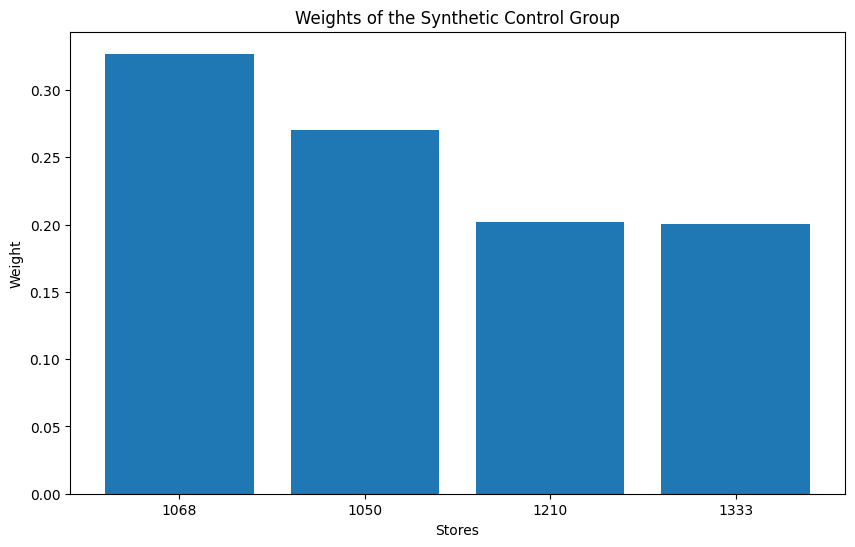

In [0]:
# Save synthetic control data to Databricks DBFS
synthetic_control_df.to_csv(get_synthetic_control_df_path)

# Plot the weights of the synthetic control group
print(f"best stores after final optimization={best_stores_final}, weights={weights}")
plt.figure(figsize=(10, 6))
plt.bar(range(len(best_stores_final)), weights, tick_label=[control_data_columns[i] for i in best_stores_final])
plt.title('Weights of the Synthetic Control Group')
plt.xlabel('Stores')
plt.ylabel('Weight')
plt.show()

In [0]:
# Filter data for pre-treatment period
all_results_data_pre_treatment = all_results_data[all_results_data.index < pd.to_datetime(get_treatment_start)]

# Create a time variable
all_results_data_pre_treatment['Time'] = range(1, len(all_results_data_pre_treatment) + 1)

# Create a outcome variable
all_results_data_pre_treatment['Outcome'] = all_results_data_pre_treatment['treated_revenue'] - all_results_data_pre_treatment['synthetic_revenue']

# Define the regression formula
formula = 'Outcome ~ Time'

# Fit the model
model = sm.OLS.from_formula(formula, data=all_results_data_pre_treatment).fit()

# print the result
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6619
Date:                Sun, 11 Aug 2024   Prob (F-statistic):              0.416
Time:                        12:24:53   Log-Likelihood:                -1214.8
No. Observations:                1036   AIC:                             2434.
Df Residuals:                    1034   BIC:                             2444.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0039      0.049     -0.079      0.9

In [0]:
display(spark.table("platform.xref.c4c_store").filter(f.col("storeno").isin(1068, 1050, 1210, 1333)))

storeno siteplanningid wsaapid storename storelegalname sitetype sapstoretype status lasttradingdate openeddate district city postalcode countryname country latitude longitude timezone phone region subregion regionclassification distributiontype realestate contractlease productfocus storetype storeconcept partnername publicfacingflag publicfacingname flagshipmarketflag flagshipmarketcity origin climate productivityband strategicsegment collectinstore sizeconversion ecommercehub grossinternalspace_ft totalfohnetsellingspace_ft totalbohspace_ft voidspaceincatrium_ft createddate lastmodifieddate market submarket alterations_text ecoreproofing_text embossing_via_proximity_store_lfc_text embroidery_via_proximity_store_lfc_text instore_embossing_text instore_embroidery_text leather_repairs_text leather_restoreconditioning_text outwear__apparel_repairs_text reproofing_text programme_text bpg_sales_pricelist_text z_sdk_sslutext customer_data_capturetext omnichannelnode digitalreturnstext planningstockregiontext ocregion ocregiontext numberoffittingrooms numberofcustomerlifts deptstorelinkedsite tier1 geo_location address_description street_name postal_code 1050 ES0021 BARCELREG Paseo de Gracia Barcelona Burberry (Spain) Retail S.L. Store Mainline Open 0000-00-00 00:00:00 2002-08-20 00:00:00 Barcelona Spain ES 41.39232 2.16499 (UTC+01:00) Central European Time +34 93 215 8104 EMEIA EUROPE Retail Stand Alone Direct Owned Multi category Flagship Lite Refresh True Paseo de Gracia Not captured A1 Urban Led Yes UK GB20 21937.39 13169.21 5967.62 2800.56 2011-10-15 00:00:00 2024-02-01 14:20:42 SPAIN NO_SUBMARKET_EMEIA Yes Yes No No Yes No Yes Yes Yes No Focus First GB Yes Yes True Yes EMEIA ES SPAIN 0 0 Yes 41.39232, 2.16499 Paseo de Gracia 56, Barcelona, 08007, Spain Paseo de Gracia 56 08007 1068 GB0024 MUKRMANCHSTR New Cathedral St. Manchester Burberry Ltd UK Store Mainline Closed 2024-02-29 00:00:00 2007-03-23 00:00:00 Manchester United Kingdom GB 53.48385 -2.24522 (UTC+00:00) Greenwich Mean Time with daylight saving time (UK) +44 161 833 9065 EMEIA UK & IRELAND Retail Stand Alone Direct Owned Multi category Stand Alone HFH False New Cathedral Street Not captured B3 Aspirational Led No UK GB20 5444.38 3729.48 1015.78 698.9 2011-10-15 00:00:00 2024-04-05 12:01:54 UNITED_KINGDOM NO_SUBMARKET_EMEIA No No No No No No Yes Yes Yes Yes GB Yes Yes True Yes EMEIA GB UK 0 0 No 53.48385, -2.24522 New Cathedral Street, Manchester, Greater Manchester, M1 1AD, United Kingdom New Cathedral Street M1 1AD 1210 NL0416 AMSTREG2 PC Hooftstraat 50 Amsterdam Burberry Netherlands BV Store Mainline Open 0000-00-00 00:00:00 2012-02-27 00:00:00 Amsterdam Netherlands NL 52.361174 4.880483 (UTC+01:00) Central European Time +31 207 194 980 EMEIA EUROPE Retail Stand Alone Direct Owned Multi category Stand Alone Sloane St. Concept True P.C. Hooftstraat Not captured B3 Aspirational Led Yes UK GB20 6234.99 3941.09 1348.82 954.0 2011-10-18 00:00:00 2023-11-21 15:51:08 NETHERLANDS NO_SUBMARKET_EMEIA Yes Yes No No No No Yes Yes Yes No GB Yes Yes True Yes EMEIA NL NETHERLANDS 0 0 No 52.361174, 4.880483 P.C. Hooftstraat 50, Amsterdam, 1071 BP, Netherlands P.C. Hooftstraat 50 1071 BP 1333 FR9883 GLMW3F Galeries Lafayette Paris MW 3F Burberry France SASU Store Open 0000-00-00 00:00:00 2019-11-26 00:00:00 Paris France FR 48.87341 2.330850000000055 (UTC+01:00) Central European Time +33 14 282 3456 EMEIA EUROPE Retail Concession Direct Owned Mens Concession Sloane St. Concept True Galeries Lafayette Yes Paris Not captured UK GB20 779.1 691.92 226.04 87.19 2019-10-07 10:26:19 2024-06-07 08:20:46 FRANCE NO_SUBMARKET_EMEIA Yes No No No No No Yes No Yes No Focus First GB True EMEIA FR FRANCE 0 0 Yes 48.87341, 2.330850000000055 null null null

In [0]:
all_results_data['Post'] = ((all_results_data.index >= pd.to_datetime(get_treatment_start))).astype(int)
all_results_data['Diff'] = all_results_data['treated_revenue'] - all_results_data['synthetic_revenue']

model = sm.OLS(all_results_data['Diff'], sm.add_constant(all_results_data[['Post']])).fit()
print(model.summary())

def get_stats_table(results, model_name):
   r2 = r2_score(results['treated_revenue'], results[model_name])
   mse = mean_squared_error(results['treated_revenue'], results[model_name])
   mape = np.mean(np.abs((results['treated_revenue'] - results[model_name]) / results['treated_revenue'])) * 100
   return pd.DataFrame({
       'R2': [r2],
       'MAPE(%)': [mape],
       'MSE': [mse]
   }, index=[model_name])

synthetic_did_stats = get_stats_table(all_results_data, 'synthetic_revenue')
stats_table = synthetic_did_stats

print(stats_table)

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     88.56
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           2.95e-20
Time:                        12:24:56   Log-Likelihood:                -1259.9
No. Observations:                1065   AIC:                             2524.
Df Residuals:                    1063   BIC:                             2534.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0381      0.025     -1.553      0.1

In [0]:
model_df = pd.DataFrame({
    'Variable': model.params.index,
    'Coefficient': model.params.values,
    'Std Error': model.bse,
    't-Statistic': model.tvalues,
    'P>|t|': model.pvalues,
    '95% CI Lower': model.conf_int()[0],
    '95% CI Upper': model.conf_int()[1]
})

print(model_df)

      Variable  Coefficient  Std Error  t-Statistic  P>|t|  95% CI Lower  \
const    const         -0.0        0.0         -1.6    0.1          -0.1   
Post      Post          1.4        0.1          9.4    0.0           1.1   

       95% CI Upper  
const           0.0  
Post            1.7  


In [0]:
def calculate_uplift(treatment_period, model_column, original_mean, original_std):
    treatment_sum_actual_standardized = treatment_period['treated_revenue'].sum()
    treatment_sum_model_standardized = treatment_period[model_column].sum()
    
    # Convert the sums back to the original values
    treatment_sum_actual = treatment_sum_actual_standardized * original_std + original_mean * len(treatment_period)
    treatment_sum_model = treatment_sum_model_standardized * original_std + original_mean * len(treatment_period)
    
    uplift_absolute = treatment_sum_actual - treatment_sum_model
    uplift_percentage = (uplift_absolute / treatment_sum_model) * 100

    return treatment_sum_model, uplift_absolute, uplift_percentage

post_treatment_period = (all_results_data.index >= pd.to_datetime(get_treatment_start)) & (all_results_data.index <= pd.to_datetime(get_treatment_end))
treatment_period = all_results_data.loc[post_treatment_period]

# Calculate the actual absolute uplift and percentage uplift
treatment_sum_model, uplift_synthetic_did_absolute, uplift_synthetic_did_percentage = calculate_uplift(treatment_period, 'synthetic_revenue', treated_means, treated_stds)

print(f'Assumed Total Revenue without Treatement: {treatment_sum_model}')
print(f'Synthetic DiD Absolute Uplift: {uplift_synthetic_did_absolute}')
print(f'Synthetic DiD Percentage Uplift: {uplift_synthetic_did_percentage:.2f}%')

Assumed Total Revenue without Treatement: 1057679.6121887723
Synthetic DiD Absolute Uplift: 857774.1078112274
Synthetic DiD Percentage Uplift: 81.10%


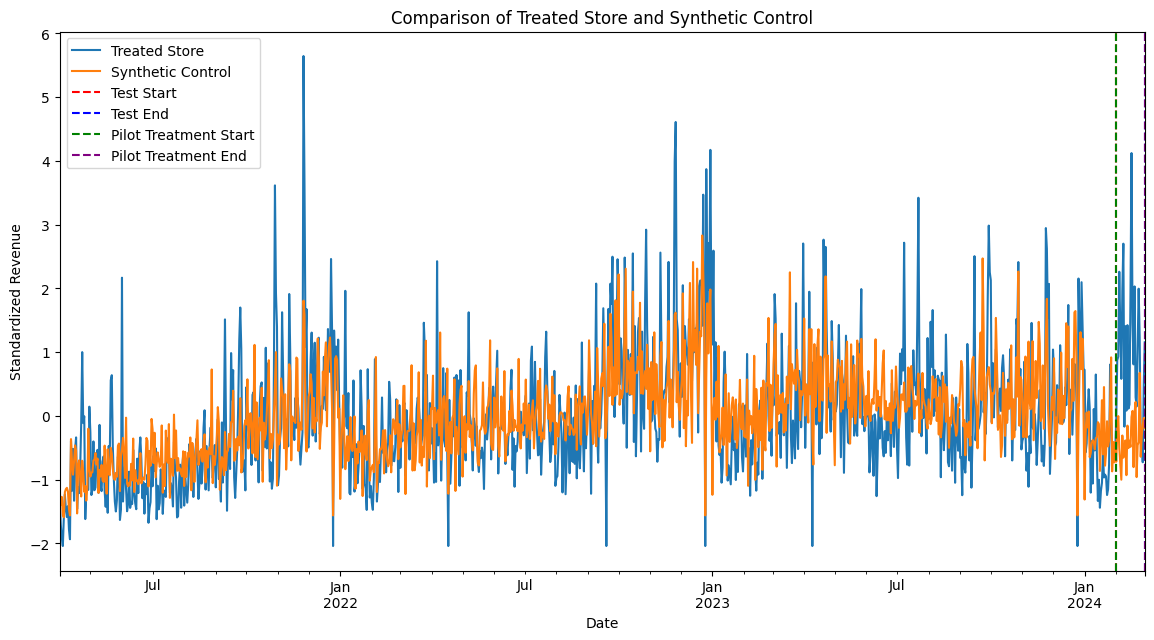

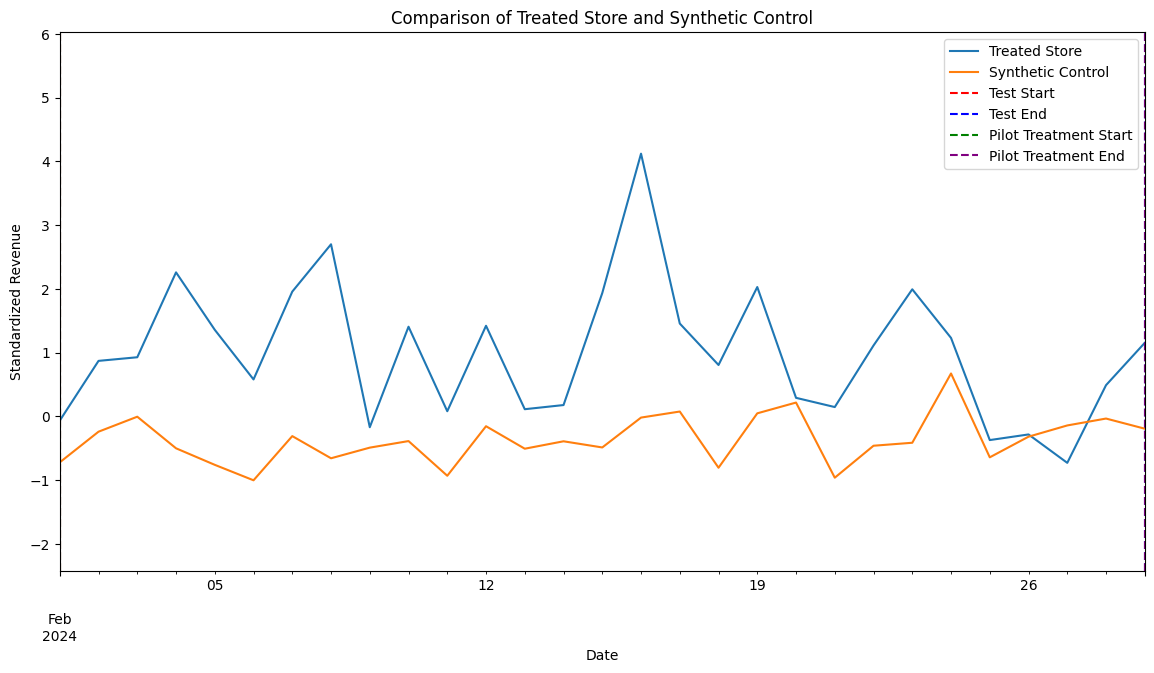

In [0]:
def plot_results(all_results_data, test_start, test_end, pilot_treatment_start, pilot_treatment_end, zoom_start=None, zoom_end=None):
   all_results_data = all_results_data.rename(
       columns={
           'treated_revenue': 'Treated Store',
           'synthetic_revenue': 'Synthetic Control'
       }
   )
   fig, ax = plt.subplots(figsize=(14, 7))
   all_results_data[['Treated Store', 'Synthetic Control']].plot(ax=ax)
   plt.axvline(x=test_start, color='red', linestyle='--', label='Test Start')
   plt.axvline(x=test_end, color='blue', linestyle='--', label='Test End')
   plt.axvline(x=pilot_treatment_start, color='green', linestyle='--', label='Pilot Treatment Start')
   plt.axvline(x=pilot_treatment_end, color='purple', linestyle='--', label='Pilot Treatment End')
   plt.title('Comparison of Treated Store and Synthetic Control')
   plt.xlabel('Date')
   plt.ylabel('Standardized Revenue')
   plt.legend()

   if zoom_start and zoom_end:
       plt.xlim(zoom_start, zoom_end)

   plt.show()

plot_results(all_results_data, get_test_start, get_test_end, get_treatment_start, get_treatment_end)
plot_results(all_results_data, get_test_start, get_test_end, get_treatment_start, get_treatment_end, get_treatment_start, get_treatment_end)

Pre-Treatment Daily RMSE: 12843.691210044713
Treatment Daily RMSE: 30456.833718775546
Pre-Treatment Weekly RMSE: 13241.428428480976
Treatment Weekly RMSE: 16248.014467052417


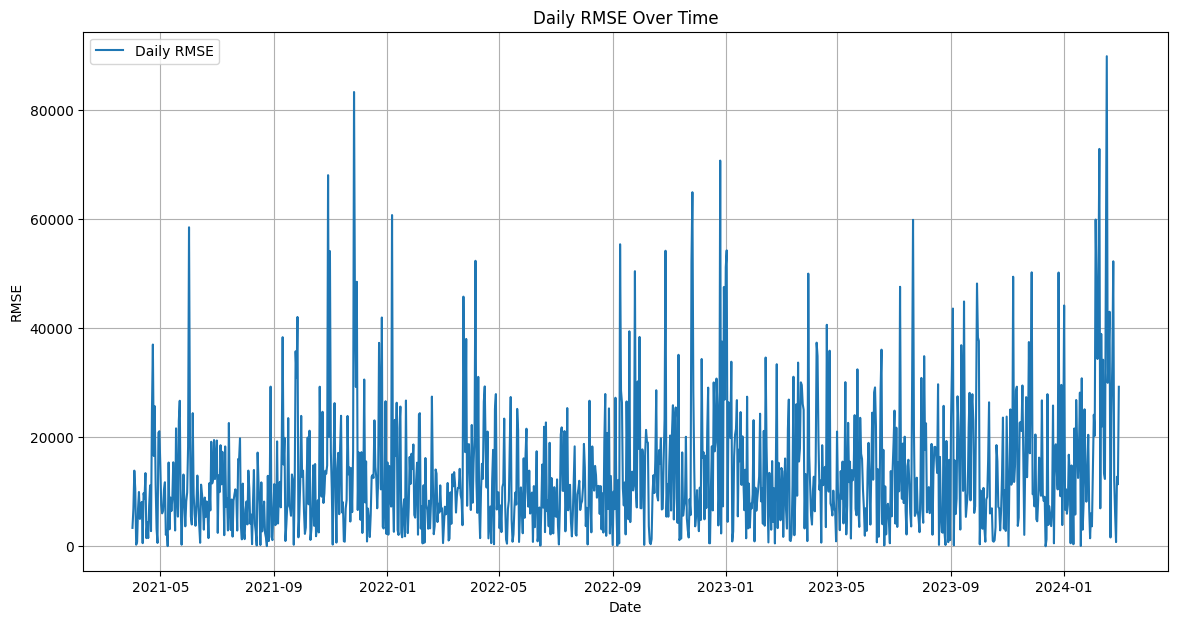

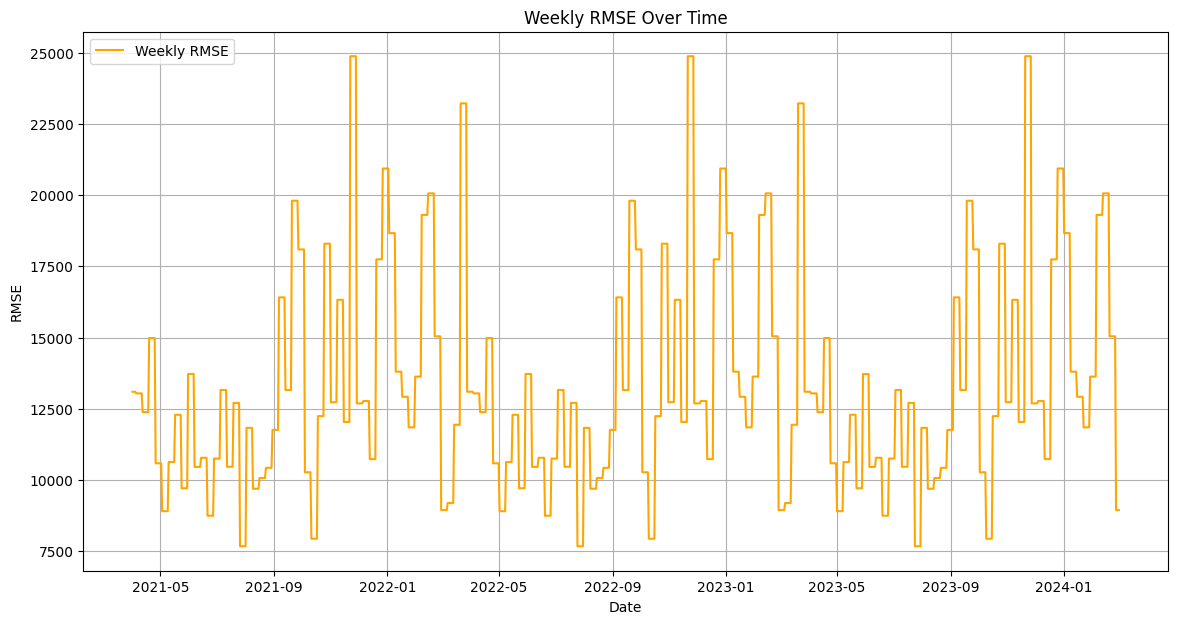

In [0]:
# Create a new DataFrame to store the reverse-standardized data
all_results_reverse = all_results_data.copy()

# Reverse the standardization
all_results_reverse['treated_revenue'] = (
    all_results_data['treated_revenue'] * treated_stds + treated_means
)
all_results_reverse['synthetic_revenue'] = (
    all_results_data['synthetic_revenue'] * treated_stds + treated_means
)

# Calculate daily RMSE
all_results_reverse['daily_rmse'] = np.sqrt(
    (all_results_reverse['treated_revenue'] - 
     all_results_reverse['synthetic_revenue']) ** 2
)

# Calculate weekly RMSE
all_results_reverse['week_number'] = all_results_reverse.index.isocalendar().week
weekly_rmse = all_results_reverse.groupby('week_number')['daily_rmse'].mean()

# Merge daily and weekly RMSE results
all_results_reverse['weekly_rmse'] = all_results_reverse['week_number'].map(weekly_rmse)

# Pre-treatment period
pre_treatment_period = all_results_reverse.index < get_treatment_start

# Treatment period
treatment_period = (all_results_reverse.index >= get_treatment_start) & \
                   (all_results_reverse.index <= get_treatment_end)
                   
# Calculate average daily and weekly RMSE
daily_rmse_pre_treatment = all_results_reverse.loc[pre_treatment_period, 'daily_rmse'].mean()
daily_rmse_treatment = all_results_reverse.loc[treatment_period, 'daily_rmse'].mean()

weekly_rmse_pre_treatment = all_results_reverse.loc[pre_treatment_period, 'weekly_rmse'].mean()
weekly_rmse_treatment = all_results_reverse.loc[treatment_period, 'weekly_rmse'].mean()

# Output the results
print(f"Pre-Treatment Daily RMSE: {daily_rmse_pre_treatment}")
print(f"Treatment Daily RMSE: {daily_rmse_treatment}")

print(f"Pre-Treatment Weekly RMSE: {weekly_rmse_pre_treatment}")
print(f"Treatment Weekly RMSE: {weekly_rmse_treatment}")

# Plot Daily RMSE
plt.figure(figsize=(14, 7))
plt.plot(all_results_reverse.index, all_results_reverse['daily_rmse'], label='Daily RMSE')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.title('Daily RMSE Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot Weekly RMSE
plt.figure(figsize=(14, 7))
plt.plot(all_results_reverse.index, all_results_reverse['weekly_rmse'], label='Weekly RMSE', color='orange')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.title('Weekly RMSE Over Time')
plt.legend()
plt.grid(True)
plt.show()

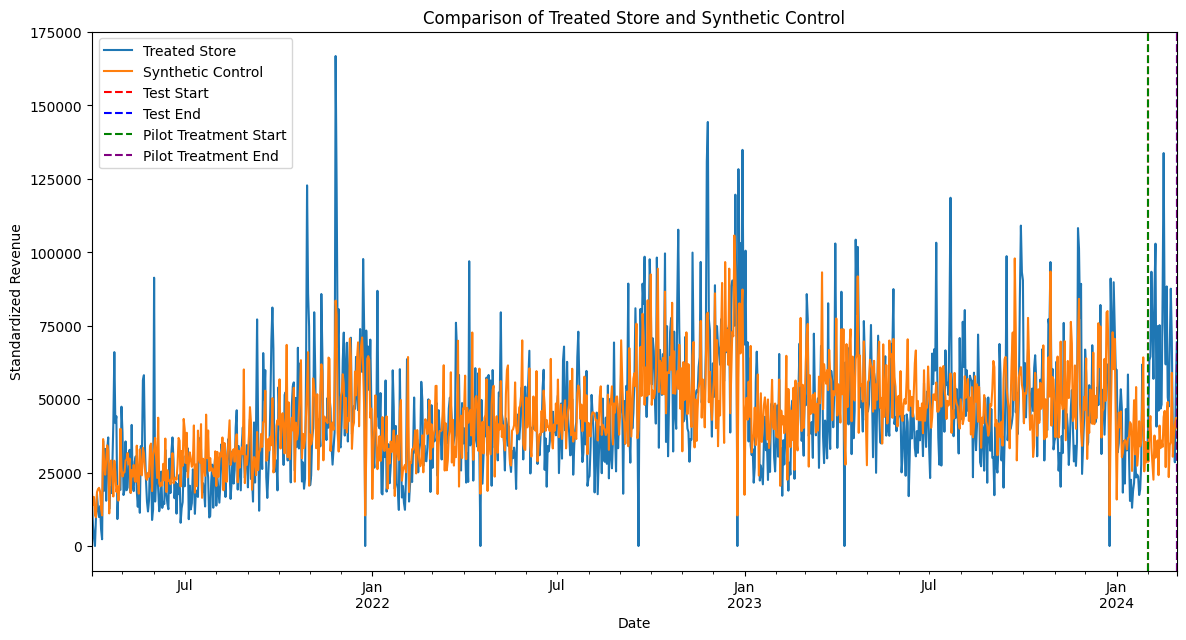

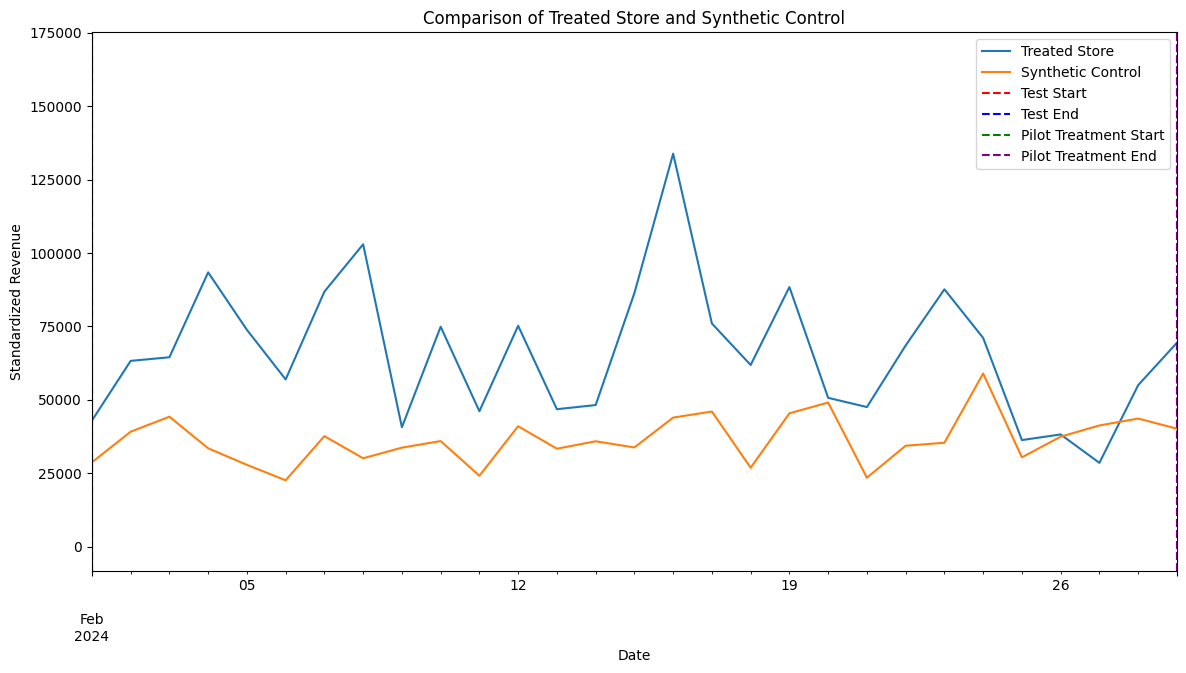

In [0]:
plot_results(all_results_reverse, get_test_start, get_test_end, get_treatment_start, get_treatment_end)
plot_results(all_results_reverse, get_test_start, get_test_end, get_treatment_start, get_treatment_end, get_treatment_start, get_treatment_end)